# Install Packages


In [1]:
pip install openai==0.27.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.54.4
    Uninstalling openai-1.54.4:
      Successfully uninstalled openai-1.54.4


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

from datetime import datetime
from pandas.tseries.offsets import QuarterBegin

import requests
from io import StringIO

import openai
from google.colab import drive

import re
import ast

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
drive.mount('/content/drive')

file = open('/content/drive/MyDrive/GT/API_KEYS/openai_outlier_key.txt', 'r')
openai.api_key = file.read().strip()
file.close()


Mounted at /content/drive


# 1. LOAD IN DATA

## 1.1 Time-series dataset

In [17]:
file_id = '1WVpJRZ8Hr9cp9zUgfC1OWDa4udDDTk3E'
url = f'https://drive.google.com/uc?id={file_id}'

response = requests.get(url)
csv_content = response.content.decode('utf-8')

original_ts = pd.read_csv(StringIO(csv_content))
original_ts['day_begin'] = pd.to_datetime(original_ts['day_begin'])

original_ts = original_ts.sort_values('day_begin',ascending=False)
data_ts = original_ts.copy()

In [18]:
data_ts['metric_category_group'].unique()

array(['Net Bookings (C$)', 'Budgets', 'Budget Utilization', 'eCPC',
       'CTR', 'Impressions', 'eCPM', 'Clicks', 'Gross Bookings (USD)',
       'LAN Revenue Adoption', 'FUV', 'Inventory', 'Matched Requests',
       'EFS', 'Coverage'], dtype=object)

In [19]:
data_ts.head()

,day_begin,line_of_business,product,segment,vertical,objective,region,metric_category_group,metric_value_num,metric_value_den
734473,2024-09-22,LMS,OTHER,ESG,Financial Services,ENGAGEMENT,NAMER,Net Bookings (C$),442.00,NaN
578001,2024-09-22,LMS,FEED,ESG,Retail,LEAD_GENERATION,APAC,Net Bookings (C$),3742.00,NaN
18261,2024-09-22,LMS,OTHER,ESG,Professional Services,TALENT_LEAD,NAMER,Budgets,0.00,NaN
798730,2024-09-22,LMS,OTHER,ESG,Financial Services,WEBSITE_CONVERSION,NAMER,Budget Utilization,24800.00,0.00
321987,2024-09-22,LMS,FEED,ESG,PE & VC,WEBSITE_VISIT,APAC,Net Bookings (C$),50.00,NaN


## 1.2 Aggregated Report dataset

In [20]:
file_id = '1zJL3qcVfypFilxdo9z8xnPkh72fHXvtn'
url = f'https://drive.google.com/uc?id={file_id}'

response = requests.get(url)
csv_content = response.content.decode('utf-8')

original_report = pd.read_csv(StringIO(csv_content))

In [21]:
aggregated_report = original_report.copy()
aggregated_report.head()

,line_of_business,product,segment,region,vertical,objective,metric_category_group,chart_label,period_label,current_num,current_den,prev_period_num,prev_period_den,prev_year_num,prev_year_den
0,LMS,FEED,ESG,APAC,Education,BRAND_AWARENESS,Net Bookings (C$),L7D,NaN,13175,0,13898,0,32240,0
1,LMS,FEED,ESG,NAMER,Education,ENGAGEMENT,Net Bookings (C$),Monthly-to-date,2024-9,44228,0,32809,0,66622,0
2,LMS,FEED,ESG,EMEAL,Education,WEBSITE_CONVERSION,Net Bookings (C$),Quarterly-to-date,FY24Q4,1773797,0,1845475,0,1484840,0
3,LMS,FEED,ESG,EMEAL,Education,ENGAGEMENT,Net Bookings (C$),Monthly-to-date,2024-8,110392,0,190359,0,45819,0
4,LMS,FEED,ESG,NAMER,Education,VIDEO_VIEW,Net Bookings (C$),Weekly,2024-09-15,32005,0,20776,0,17080,0


In [22]:
aggregated_report['metric_category_group'].unique()

array(['Net Bookings (C$)', 'CTR', 'Clicks', 'Coverage', 'EFS', 'FUV',
       'Gross Bookings (USD)', 'Impressions', 'Inventory', 'eCPC', 'eCPM',
       'Matched Requests', 'Budget Utilization', 'Budgets',
       'LAN Revenue Adoption'], dtype=object)

### 'period_label' column edit

We change the period_label to the same format and fill in the missing date for L7D

In [23]:
# Handling NaN replacement for 'L7D' in 'period_label'
aggregated_report.loc[(aggregated_report['chart_label'] == 'L7D') & (aggregated_report['period_label'].isna()), 'period_label'] = '2024-09-22'

# Function to convert the period_label to a proper date format
def convert_to_date(label):
    if isinstance(label, str):
        label = label.strip()

        if 'FY' in label:
            year = int(label[2:4]) + 2000  # Extract the fiscal year
            quarter = label[-2:]
            if quarter == 'Q1':
                return pd.Timestamp(f'{year}-01-01')
            elif quarter == 'Q2':
                return pd.Timestamp(f'{year}-04-01')
            elif quarter == 'Q3':
                return pd.Timestamp(f'{year}-07-01')
            elif quarter == 'Q4':
                return pd.Timestamp(f'{year}-10-01')

        # Handle complete date-like labels (e.g., '2024-09-20')
        try:
            return pd.to_datetime(label, format='%Y-%m-%d', errors='raise')
        except (ValueError, TypeError):
            pass

        # Handle month-only labels like '2024-09'
        try:
            return pd.to_datetime(label, format='%Y-%m', errors='raise')
        except (ValueError, TypeError):
            pass

    return pd.NaT

aggregated_report['period_label_converted'] = aggregated_report['period_label'].apply(lambda x: convert_to_date(x) if pd.notna(x) else pd.NaT)
aggregated_report = aggregated_report.sort_values(by='period_label_converted')

### We calcualte the percentage for certain groups of 'metric_category_group', if there's 0 den then we take the value.


In [24]:
def calculate_value(row, period_type):
    """
    Calculate the transformed value based on the metric category group and period type.

    Parameters:
    - row: The DataFrame row containing the data.
    - period_type: The type of period to use for calculation ('current', 'prev_period', 'prev_year').

    Returns:
    - Transformed value based on the metric category group.
    """

    percentage_metrics = [
        'Budget Utilization', 'CTR', 'Coverage',
        'LAN Revenue Adoption', 'eCPC', 'eCPM'
    ]

    num_col = f"{period_type}_num"
    den_col = f"{period_type}_den"

    if row["metric_category_group"] in percentage_metrics:
        if row[den_col] != 0:  # Avoid division by zero
            return row[num_col] / row[den_col]
        else:
            return None
    else:
        return row[num_col]

def apply_transformations(aggregated_report):
    """
    Apply the transformations to the aggregated report DataFrame.

    Parameters:
    - aggregated_report: The input DataFrame to transform.

    Returns:
    - Transformed DataFrame with new columns for transformed values.
    """

    for period in ['current', 'prev_period', 'prev_year']:
        transformed_col = f"{period}_transformed_value"
        aggregated_report[transformed_col] = aggregated_report.apply(
            lambda row: calculate_value(row, period), axis=1
        )

    # Drop unnecessary columns
    aggregated_report.drop(columns=[
        'current_num', 'current_den',
        'prev_period_num', 'prev_period_den',
        'prev_year_num', 'prev_year_den'
    ], inplace=True)

    return aggregated_report

aggregated_report = apply_transformations(aggregated_report)
aggregated_report

,line_of_business,product,segment,region,vertical,objective,metric_category_group,chart_label,period_label,period_label_converted,current_transformed_value,prev_period_transformed_value,prev_year_transformed_value
20863,LMS,OTHER,ESG,NAMER,Professional Services,TALENT_LEAD,Budget Utilization,Quarterly-to-date,FY24Q2,2024-04-01,1.00,0.99,0.95
18708,LMS,OTHER,ESG,NAMER,Infrastructure & Connectivity,WEBSITE_CONVERSION,Net Bookings (C$),Quarterly-to-date,FY24Q2,2024-04-01,323715.00,306793.00,256358.00
11342,LMS,LAN,ESG,EMEAL,SaaS,BRAND_AWARENESS,Net Bookings (C$),Quarterly-to-date,FY24Q2,2024-04-01,406634.00,343582.00,464366.00
22637,LMS,OTHER,ESG,NAMER,SaaS,LEAD_GENERATION,Budget Utilization,Quarterly-to-date,FY24Q2,2024-04-01,0.86,0.87,0.87
13971,LMS,OTHER,ESG,NAMER,Financial Services,WEBSITE_TRAFFIC,Budget Utilization,Quarterly-to-date,FY24Q2,2024-04-01,1.01,1.02,0.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12774,LMS,NOT USED,ESG,NOT USED,NOT USED,NOT USED,Net Bookings (C$),Outlook,FY25Q3,2025-07-01,470891111.00,470891111.00,431775509.00
12769,LMS,NOT USED,OTHER,NOT USED,NOT USED,NOT USED,Budget Utilization,Outlook,FY25Q3,2025-07-01,0.93,0.93,0.93
12768,LMS,NOT USED,OTHER,NOT USED,NOT USED,NOT USED,Budget Utilization,Outlook,FY25Q4,2025-10-01,0.90,0.90,0.93
12770,LMS,NOT USED,OTHER,NOT USED,NOT USED,NOT USED,Budgets,Outlook,FY25Q4,2025-10-01,538404695.00,538404695.00,477600991.00


### Filter for Outlook only

In [25]:
outlook_df = aggregated_report[aggregated_report['chart_label'].isin(['Outlook'])]
# outlook_df

In [26]:
outlook_filter_df = aggregated_report[aggregated_report['chart_label'].isin(['Outlook'])]
outlook_filter_df = outlook_filter_df[outlook_filter_df["period_label"] == "FY25Q1"]

In [27]:
outlook_filter_df.head()

,line_of_business,product,segment,region,vertical,objective,metric_category_group,chart_label,period_label,period_label_converted,current_transformed_value,prev_period_transformed_value,prev_year_transformed_value
12775,LMS,NOT USED,ESG,NOT USED,NOT USED,NOT USED,Net Bookings (C$),Outlook,FY25Q1,2025-01-01,459558890.00,459558890.00,430622825.00
12773,LMS,NOT USED,OTHER,NOT USED,NOT USED,NOT USED,Budgets,Outlook,FY25Q1,2025-01-01,463294869.00,463294869.00,438426050.00
12767,LMS,NOT USED,OTHER,NOT USED,NOT USED,NOT USED,Budget Utilization,Outlook,FY25Q1,2025-01-01,0.93,0.93,0.92


# OTHER METRIC CATEGORY


1. label each metric_category_group according to whether they supply-side or demand-side (col: "supply_or_demand")
2. get average metric value grouped by {product, segment, metric_category_group}
3. calculate deviation from average value (possible std or just diff)
4. identify high deviation

Demand Metrics

These are metrics that typically drive the demand side by showing engagement or performance:

* Net Bookings (C$)
* Gross Bookings (USD)
* eCPC (Effective Cost Per Click)
* CTR (Click-Through Rate)
* Impressions
* Clicks


Supply Metrics

These metrics relate to the availability or constraints that impact budget usage from the supply side:

* Budgets
* eCPM (Effective Cost Per Mille)
* Matched Requests
* FUV (Fill Under Volume)
* EFS (Estimated Fill Rate)
* LAN Revenue Adoption
* Inventory
* Coverage

In [28]:
data_ts = data_ts.sort_values('day_begin',ascending=False)

data_ts = data_ts[data_ts['day_begin'] >= '2024-07-01']
data_ts['metric_value_den'].replace(0, np.nan, inplace=True)

data_ts["metric_value_den"] = data_ts.groupby(
    ["line_of_business", "product", "segment", "vertical", "objective", "region", "metric_category_group"]
)["metric_value_den"].ffill()

def safe_divide(row):
    if row["metric_category_group"] == "Budget Utilization":
        if row["metric_value_den"] != 0:
            return row["metric_value_num"] / row["metric_value_den"]
        else:
            return None
    else:
        return row["metric_value_num"]

data_ts["transformed_value"] = data_ts.apply(safe_divide, axis=1)


ts_filtered_df = data_ts[data_ts['metric_category_group'].isin(outlook_df['metric_category_group'].unique())]

ts_filtered_df.head()

<ipython-input-28-8f1c4ae2086a>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_ts['metric_value_den'].replace(0, np.nan, inplace=True)


,day_begin,line_of_business,product,segment,vertical,objective,region,metric_category_group,metric_value_num,metric_value_den,transformed_value
734473,2024-09-22,LMS,OTHER,ESG,Financial Services,ENGAGEMENT,NAMER,Net Bookings (C$),442.00,NaN,442.00
270488,2024-09-22,LMS,OTHER,ESG,Professional Services,BRAND_AWARENESS,EMEAL,Budget Utilization,24985.00,NaN,NaN
851235,2024-09-22,LMS,FEED,ESG,Industrial,LEAD_GENERATION,APAC,Net Bookings (C$),6137.00,NaN,6137.00
928721,2024-09-22,LMS,OTHER,ESG,Professional Services,JOB_APPLICANT,EMEAL,Budgets,0.00,NaN,0.00
623371,2024-09-22,LMS,OTHER,ESG,Education,ENGAGEMENT,EMEAL,Budgets,0.00,NaN,0.00


In [29]:
STANDARD_DEVIATION_THRESHOLD = 3

# Define the mapping for supply or demand classification
metric_classification = {
    'Gross Bookings (USD)': 'Demand',
    'eCPC': 'Demand',
    'CTR': 'Demand',
    'Impressions': 'Demand',
    'Clicks': 'Demand',
    'Net Bookings (C$)': 'Demand',
    'Budgets': 'Supply',
    'eCPM': 'Supply',
    'Matched Requests': 'Supply',
    'FUV': 'Supply',
    'EFS': 'Supply',
    'LAN Revenue Adoption': 'Supply',
    'Inventory': 'Supply',
    'Coverage': 'Supply'
}

non_outlook_metrics = data_ts[~data_ts['metric_category_group'].isin(outlook_df['metric_category_group'].unique())]
non_outlook_metrics['day_of_week'] = pd.to_datetime(non_outlook_metrics['day_begin']).dt.day_name()

non_outlook_metrics['supply_or_demand'] = non_outlook_metrics['metric_category_group'].map(metric_classification)

grouped_avg = non_outlook_metrics.groupby(
    ['product', 'segment', 'objective', 'metric_category_group', 'day_of_week']
)['transformed_value'].mean().reset_index(name='average_value')

non_outlook_metrics = pd.merge(non_outlook_metrics, grouped_avg, on=['product', 'segment', 'objective', 'metric_category_group', 'day_of_week'])

non_outlook_metrics['deviation'] = abs(non_outlook_metrics['transformed_value'] - non_outlook_metrics['average_value'])

std_deviation = non_outlook_metrics.groupby('metric_category_group')['deviation'].std().reset_index(name='std_deviation')
non_outlook_metrics = pd.merge(non_outlook_metrics, std_deviation, on='metric_category_group')

non_outlook_metrics['is_high_deviation'] = non_outlook_metrics['deviation'] > STANDARD_DEVIATION_THRESHOLD * non_outlook_metrics['std_deviation']

<ipython-input-29-0281e9648229>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_outlook_metrics['day_of_week'] = pd.to_datetime(non_outlook_metrics['day_begin']).dt.day_name()
<ipython-input-29-0281e9648229>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_outlook_metrics['supply_or_demand'] = non_outlook_metrics['metric_category_group'].map(metric_classification)


In [30]:
non_outlook_metrics.groupby('is_high_deviation').count()

,day_begin,line_of_business,product,segment,vertical,objective,region,metric_category_group,metric_value_num,metric_value_den,transformed_value,day_of_week,supply_or_demand,average_value,deviation,std_deviation
is_high_deviation,,,,,,,,,,,,,,,,
False,14431,14431,14431,14431,0,14431,0,14431,14431,0,14431,14431,14431,14431,14431,14431
True,410,410,410,410,0,410,0,410,410,0,410,410,410,410,410,410


In [31]:
cols = [
    "day_begin",
    "product",
    "segment",
    "objective",
    "metric_category_group",
    "metric_value_num",
    "supply_or_demand",
    "average_value",
    "deviation",
    "is_high_deviation"
]

non_outlook_metric_outliers_only = non_outlook_metrics[non_outlook_metrics.is_high_deviation == True][cols]
non_outlook_metric_outliers_only.head()

,day_begin,product,segment,objective,metric_category_group,metric_value_num,supply_or_demand,average_value,deviation,is_high_deviation
2,2024-09-22,FEED,ESG,LEAD_GENERATION,eCPM,1431376352.00,Supply,1261962854.83,169413497.17,True
4,2024-09-22,LAN,ESG,BRAND_AWARENESS,Impressions,27826115.00,Demand,23645168.25,4180946.75,True
15,2024-09-22,LAN,ESG,BRAND_AWARENESS,Gross Bookings (USD),266193.00,Demand,172907.33,93285.67,True
22,2024-09-22,FEED,ESG,WEBSITE_VISIT,eCPC,860794.00,Demand,643264.33,217529.67,True
25,2024-09-22,FEED,ESG,BRAND_AWARENESS,eCPM,459037125.00,Supply,348890888.00,110146237.00,True


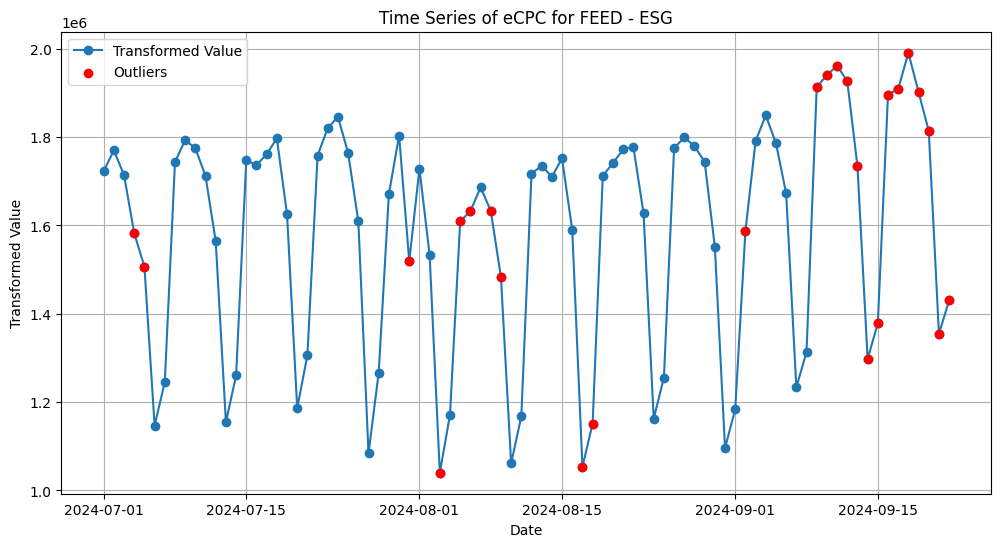

In [32]:
PRODUCT = "FEED"  # Example product
SEGMENT = "ESG"  # Example segment
OBJECTIVE = "LEAD_GENERATION"
METRIC_CATEGORY_GROUP = "eCPC"  # Example metric_category_group

filtered_data = non_outlook_metrics[
    (non_outlook_metrics['product'] == PRODUCT) &
    (non_outlook_metrics['segment'] == SEGMENT) &
    (non_outlook_metrics['objective'] == OBJECTIVE) &
    (non_outlook_metrics['metric_category_group'] == METRIC_CATEGORY_GROUP)
]

filtered_data = filtered_data.sort_values('day_begin')

plt.figure(figsize=(12, 6))
plt.plot(
    filtered_data['day_begin'],
    filtered_data['transformed_value'],
    label='Transformed Value',
    marker='o',
    linestyle='-'
)

outliers = filtered_data[filtered_data['is_high_deviation']]
plt.scatter(
    outliers['day_begin'],
    outliers['transformed_value'],
    color='red',
    label='Outliers',
    zorder=5
)

plt.title(f"Time Series of {METRIC_CATEGORY_GROUP} for {PRODUCT} - {SEGMENT}")
plt.xlabel("Date")
plt.ylabel("Transformed Value")
plt.legend()
plt.grid(True)

plt.show()

# 2. OUTLOOK ANOMALY DETECTION

Approach 1: we are comparing performance with OUTLOOK

1. Budget Utilization: Anomalies detected if BU exceeds 2 standard deviations of recent BU values.
2. Budgets & Net Bookings: Using the Outlook as our expected target, we can plot cumulative values of budgets and bookings, and forecast into the future according to growth trends (regression).


## 2.1 Outlook Approach 1: Daily Values of Budget Utilization (Std)

2024-07-01 to 2024-09-22 compaired to FYQ12025 Outlook.

For anomaly detection of BU, it is appropriate to use summary statistics to flag cases where BU exceeds beyond 2 standard deviations of the typical BU because it is a percentage value.

### 2.1.1 Anomaly Detection for Budget Utilization

Smaller threshold == more anomaly, here we used three signma upper and lower groups

In [33]:
def detect_and_plot_outliers(time_series_df, metric_category_group, stddev_drift):
    """
    Detect and plot outliers for a given metric category group across all available groupings.

    Parameters:
    - time_series_df: DataFrame containing the time series data.
    - metric_category_group: The metric category group to filter by (e.g., 'Budget Utilization').
    - stddev_drift: The standard deviation multiplier for setting outlier thresholds (default is 2).

    Returns:
    - anomalies_df: DataFrame containing detected anomalies across all groupings.
    """

    filtered_df = time_series_df[time_series_df['metric_category_group'] == metric_category_group].copy()
    filtered_df['day_begin'] = pd.to_datetime(filtered_df['day_begin'])

    std_by_groups = filtered_df.groupby(['vertical', 'objective', 'region'])['transformed_value'].std()
    avg_by_groups = filtered_df.groupby(['vertical', 'objective', 'region'])['transformed_value'].mean()

    thresholds = pd.DataFrame({
        'two_sigma_upper': avg_by_groups + (std_by_groups * stddev_drift),
        'two_sigma_lower': avg_by_groups - (std_by_groups * stddev_drift)
    }).reset_index()

    merged_df = filtered_df.merge(thresholds, on=['vertical', 'objective', 'region'], how='left')

    merged_df['anomaly'] = np.where(
        (merged_df['transformed_value'] >= merged_df['two_sigma_upper']) |
        (merged_df['transformed_value'] <= merged_df['two_sigma_lower']),
        True,
        False
    )

    anomalies_df = merged_df[merged_df['anomaly']]
    return anomalies_df

bu_anomalies = detect_and_plot_outliers(ts_filtered_df, 'Budget Utilization', 2)

### LLM Analysis Agent: Outlook - Budget Utlization

In [34]:
llm_bu_anomalies_df = bu_anomalies.drop(columns=['line_of_business', 'segment', 'metric_value_num', 'metric_value_den','two_sigma_upper','two_sigma_lower'])
llm_bu_anomalies_df.rename(columns={'transformed_value': 'metric_value'}, inplace=True)
llm_bu_anomalies_df

,day_begin,product,vertical,objective,region,metric_category_group,metric_value,anomaly
346,2024-09-21,OTHER,Travel & Leisure,LEAD_GENERATION,EMEAL,Budget Utilization,0.53,True
374,2024-09-21,OTHER,Retail,LEAD_GENERATION,APAC,Budget Utilization,0.58,True
414,2024-09-21,OTHER,Government,UNKNOWN,EMEAL,Budget Utilization,1.64,True
464,2024-09-21,OTHER,Media,WEBSITE_VISIT,EMEAL,Budget Utilization,0.59,True
488,2024-09-21,OTHER,Healthcare,WEBSITE_CONVERSION,EMEAL,Budget Utilization,0.65,True
...,...,...,...,...,...,...,...,...
23225,2024-07-01,OTHER,SaaS,UNKNOWN,NAMER,Budget Utilization,2.10,True
23238,2024-07-01,OTHER,SaaS,WEBSITE_VISIT,APAC,Budget Utilization,1.37,True
23239,2024-07-01,OTHER,Professional Services,UNKNOWN,APAC,Budget Utilization,0.27,True
23346,2024-07-01,OTHER,Education,WEBSITE_CONVERSION,EMEAL,Budget Utilization,0.98,True


In [ ]:
system_intel_relevancy = "You are a skilled data analyst adept at analyzing datasets to uncover trends, anomalies, and insights. Your expertise includes interpreting business context to deliver actionable recommendations."

context_relevancy = f"""
We have detected anomalies in budget utilization across different dimensions (products, verticals, objectives, regions). Budget utilization is expressed as a percentage (e.g., 0.6 = 60%).
Anomalies were identified statistically based on deviations exceeding 2 standard deviations from the norm, as listed in  llm_bu_anomalies_df: {llm_bu_anomalies_df}.

A key benchmark for this quarter’s budget utilization is {outlook_filter_df[outlook_filter_df['metric_category_group'] == 'Budget Utilization']['current_transformed_value'].values[0]}.
Anomalies have been classified as:
- Positive anomalies: Budget utilization exceeding the benchmark.
- Negative anomalies: Budget utilization below the benchmark.
Additionally, we have a dataset of related metrics, non_outlook_metric_outliers_only: {non_outlook_metric_outliers_only}, which captures supply- and demand-side metrics.
These metrics help explain the root causes of the detected anomalies.

--------
Your task:
Analyze the provided datasets with a business-relevant lens and deliver insights that include:

Group the budget utilization anomalies (llm_bu_anomalies_df) by region, product, vertical, and objective.
Identify areas where budget utilization failed to meet the outlook benchmark from outlook_filter_df.
Use related metrics from non_outlook_metric_outliers_only to explain anomalies in terms of:
Demand-side factors: Metrics like impressions, CTR, and clicks.
Supply-side factors: Metrics like CPM, CPC, and cost.
Explicitly mention numeric changes to highlight trends (e.g., "decreased by -18.63%" or "current value is 60 vs. benchmark 35").
Provide root cause analysis linked to supply/demand metrics with specific references to outliers, including their dates.

-------
Deliverables:

A narrative report summarizing key insights:
Highlight the most significant deviations by region, vertical, product, and objective.
Explain anomalies with root causes tied to related metrics in non_outlook_metric_outliers_only.
A summary table of noteworthy deviations with columns for:
Region, product, vertical, objective, metric value, deviation from the benchmark, and root causes.
Prioritize actionable insights where performance failed to meet the benchmark.

"""

responses_relevancy = openai.ChatCompletion.create(
  model="gpt-4o-mini", #gpt-4-turbo (expensive), gpt-3.5-turbo (cheap)
  messages=[
      {"role": "system", "content": system_intel_relevancy},
      {"role": "user", "content": context_relevancy}
  ],
  temperature=0.1,
)

budget_utilization_narrative = responses_relevancy.choices[0].message.content
print(budget_utilization_narrative)


### Narrative Report on Budget Utilization Anomalies

#### Overview
This report analyzes budget utilization anomalies detected across various dimensions, including region, product, vertical, and objective. The analysis leverages related metrics to identify root causes for these anomalies, particularly focusing on demand-side and supply-side factors. The benchmark for this quarter's budget utilization is set at approximately 0.93.

#### Key Insights

1. **Significant Deviations by Region:**
   - **EMEAL Region:**
     - Notable positive anomalies were observed in the Government vertical with a budget utilization of **1.64**, exceeding the benchmark by **70.5%**.
     - Negative anomalies were identified in the Healthcare vertical, with a utilization of **0.65**, falling short of the benchmark by **30.5%**.
   - **APAC Region:**
     - The Retail vertical showed a positive anomaly with a utilization of **1.37**, exceeding the benchmark by **47.5%**.
     - Conversely, the SaaS vertical h

### LLM Interactive Agent: Budget Utlization

In [40]:
budget_utilization_anomalies = llm_bu_anomalies_df
narrative = budget_utilization_narrative

def interactive_answer(question, narrative, datasets):
    context = (
        f"Context:\n"
        f"Narrative: {narrative}\n\n"
        f"Data Insights:\n"
        f"Budhet Utilization Anomalies Data: {datasets['summary']}\n"
        "Please answer the question based on actual dataset values, providing detailed calculations and comparisons when answering."
    )

    response = openai.ChatCompletion.create(
        model="gpt-4-turbo",
        messages=[
            {"role": "system", "content": "You are a highly knowledgeable data analyst assistant with expertise in data interpretation."},
            {"role": "user", "content": context + "\nQuestion: " + question}
        ],
        max_tokens=1000,  # Increased max tokens for detailed responses
        temperature=0.1,  # Lowering temperature for more deterministic responses
    )

    return response.choices[0].message['content'].strip()

datasets_summary = {
    "summary": budget_utilization_anomalies.describe().to_string(),
}

# Interact with the system
while True:
    question = input("Enter your question (or type 'exit' to quit): ")
    if question.strip().lower() == "exit" or question.strip() == "":
        print("Exiting the loop.")
        break
    answer = interactive_answer(question, narrative, datasets_summary)
    print(f"Answer: {answer}")
    print("------------------------------------------------------------")


Enter your question (or type 'exit' to quit): 
Exiting the loop.


#### Testing Interactive Agent Output

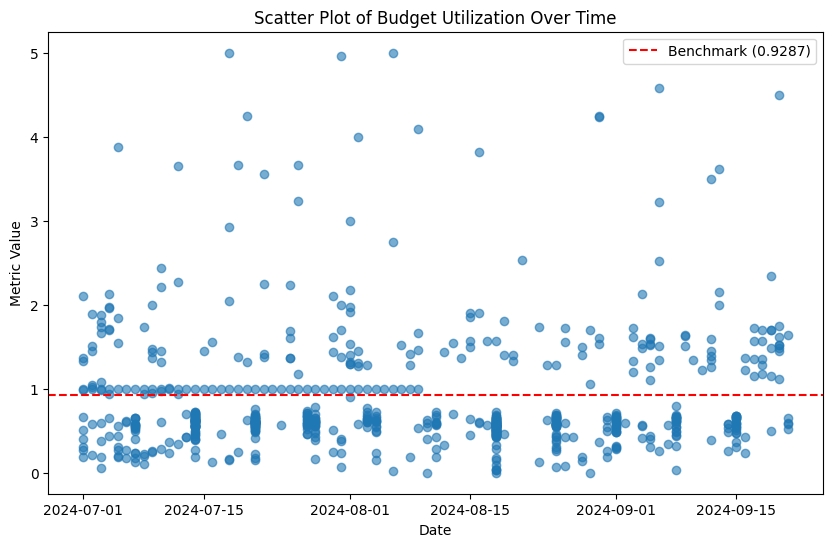

In [41]:
plt.figure(figsize=(10, 6))
plt.scatter(llm_bu_anomalies_df['day_begin'], llm_bu_anomalies_df['metric_value'], alpha=0.6)
plt.axhline(y=0.9287, color='r', linestyle='--', label='Benchmark (0.9287)')
plt.title('Scatter Plot of Budget Utilization Over Time')
plt.xlabel('Date')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

<Figure size 1000x600 with 0 Axes>

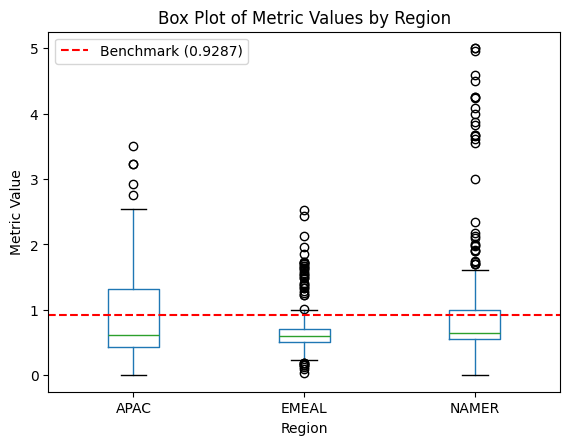

In [42]:
plt.figure(figsize=(10, 6))
llm_bu_anomalies_df.boxplot(column='metric_value', by='region', grid=False)
plt.axhline(y=0.9287, color='r', linestyle='--', label='Benchmark (0.9287)')
plt.title('Box Plot of Metric Values by Region')
plt.xlabel('Region')
plt.ylabel('Metric Value')
plt.suptitle('')  # Suppress the automatic title to avoid duplication
plt.legend()
plt.show()

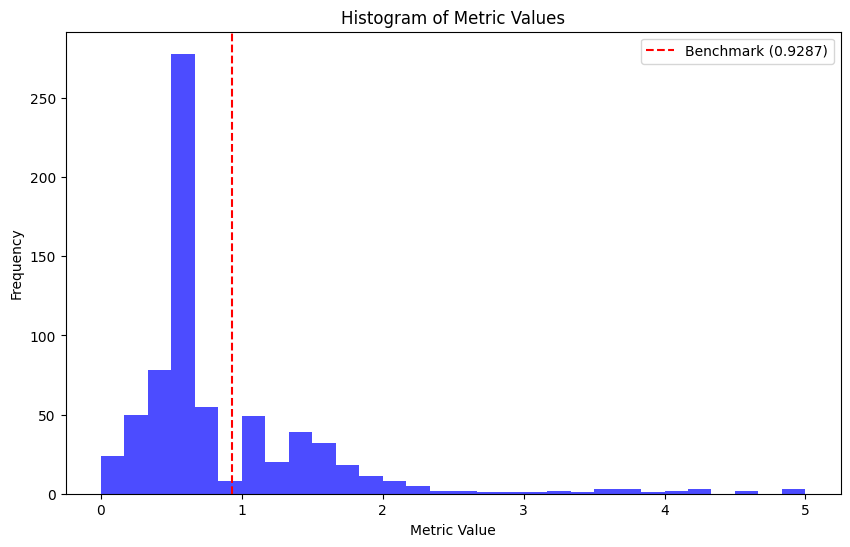

In [43]:
plt.figure(figsize=(10, 6))
plt.hist(llm_bu_anomalies_df['metric_value'], bins=30, alpha=0.7, color='blue')
plt.axvline(x=0.9287, color='red', linestyle='--', label='Benchmark (0.9287)')
plt.title('Histogram of Metric Values')
plt.xlabel('Metric Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

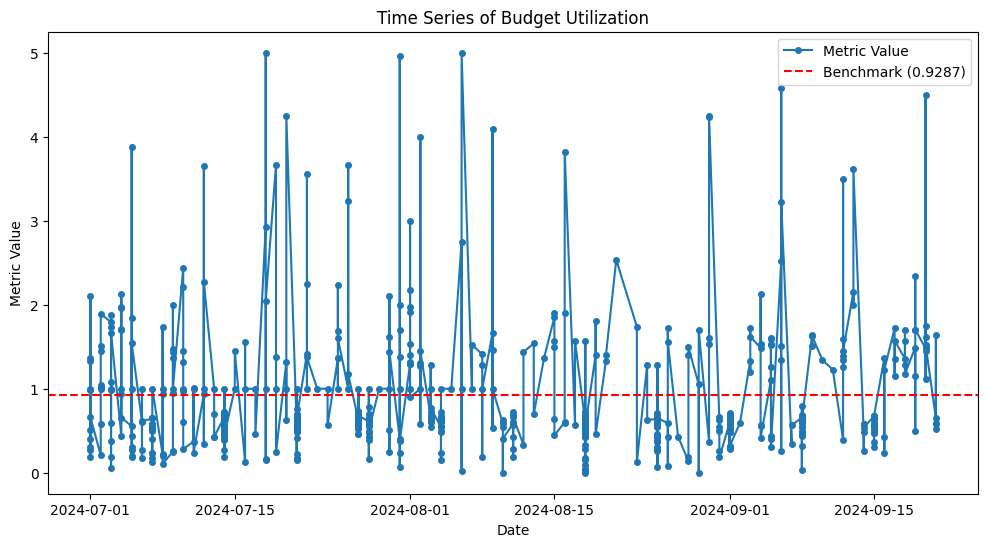

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(llm_bu_anomalies_df['day_begin'], llm_bu_anomalies_df['metric_value'], label='Metric Value', marker='o', linestyle='-', markersize=4)
plt.axhline(y=0.9287, color='r', linestyle='--', label='Benchmark (0.9287)')
plt.title('Time Series of Budget Utilization')
plt.xlabel('Date')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

### LLM Visual Agent: Outlook - Budget Utlization

In [ ]:
system_intel_relevancy = "You are a data analyst. You are very excellent at generating Python code for data analysis and visualization."

context_relevancy = f"""
We have already conducted an anomaly analysis.
Analysis Narrative: {budget_utilization_narrative}
Original Data: {llm_bu_anomalies_df}

The business outlook for Budget Utilization:{outlook_filter_df[outlook_filter_df['metric_category_group'] == 'Budget Utilization']['current_transformed_value'].values[0]}

Your task is to generate Python code that creates visualizations based on the analysis.
Specifically:
- **Outliers by Product and Objective**: Generate a combined plot (e.g., bar plot) that shows the distribution of budget utilization outliers by different products and objectives.
- **Outliers by Region and Vertical**: Generate a similar combined plot to show how the anomalies are distributed by region and vertical.
- **Overlay the Outlook **: Create a separate plot that overlays the outlook value on top of the budget utilization values for different groups
(e.g., regions, products, or verticals) to show which outliers exceed or fall short of the business benchmark.

Use the dataset and apply appropriate labels and legends for clarity.
The df name is llm_bu_anomalies_df

Python visual code:
<python code start>
[YOUR CODE HERE]
<python code end>

"""

responses_relevancy = openai.ChatCompletion.create(
  model="gpt-4o-mini", #gpt-4-turbo (expensive), gpt-3.5-turbo (cheap), #gpt-4o-mini (midway)
  messages=[
      {"role": "system", "content": system_intel_relevancy},
      {"role": "user", "content": context_relevancy}
  ],
  temperature=0.1,
)

budget_utilization_visual = responses_relevancy.choices[0].message.content
print(budget_utilization_visual)


In [ ]:
# Note, it is dangerous automatically to run LLM-generated code. Please inspect the output carefully to avoid any injection attacks.

def extract_python_code(text):
    pattern = r'```python(.*?)```'
    matches = re.findall(pattern, text, re.DOTALL)
    return [match.strip() for match in matches]

def separate_imports(code):
    tree = ast.parse(code)
    imports = []
    other_code = []

    for node in tree.body:
        if isinstance(node, (ast.Import, ast.ImportFrom)):
            imports.append(ast.unparse(node))
        else:
            other_code.append(ast.unparse(node))

    return '\n'.join(imports), '\n'.join(other_code)

def safe_exec(code_string, global_dict=None):
    safe_globals = {
        'plt': plt,
        'pd': pd,
        'sns': sns,
        'np': np,
        '__builtins__': {
            'range': range,
            'len': len,
            'zip': zip,
            'True': True,
            'False': False,
            'list': list,
            'dict': dict,
            'tuple': tuple,
            'set': set,
            'int': int,
            'float': float,
            'str': str,
            'bool': bool,
        }
    }

    if global_dict:
        safe_globals.update(global_dict)

    exec(code_string, safe_globals)

    return safe_globals

# Extract all Python code blocks
code_blocks = extract_python_code(budget_utilization_visual)

if code_blocks:
    all_imports = []
    all_main_code = []

    for code in code_blocks:
        imports, main_code = separate_imports(code)
        all_imports.append(imports)
        all_main_code.append(main_code)

    combined_imports = '\n'.join(all_imports)
    exec(combined_imports)

    global_dict = {'llm_bu_anomalies_df': llm_bu_anomalies_df}

    for i, main_code in enumerate(all_main_code, 1):
        print(f"Executing code block {i}...")
        result = safe_exec(main_code, global_dict)
        print(f"Code block {i} executed successfully.")

    print("All code blocks executed successfully.")
else:
    print("No Python code found in the AI's output.")

## 2.2 Outlook Approach 2: Daily Values of Budgets and Net Bookings (Regression)

Budgets & Net Bookings: Using the Outlook as our expected target, we can plot cumulative values of budgets and net bookings, and forecast into the future according to growth trends.

### 2.2.1 Budgets vs Outlook

In [ ]:
budgets_outlook = outlook_filter_df[outlook_filter_df['metric_category_group'] == 'Budgets']
target_value_budgets = budgets_outlook['current_transformed_value']
target_value_budgets

,current_transformed_value
12773,463294869.00


In [ ]:
def preprocess_ts_data(original_ts, value, start_date='2024-07-01'):
    """
    This function preprocesses the data by filtering based on 'metric_category_group', replacing zeros with NaN,
    and dropping the 'metric_value_den' column if it exists.

    Parameters:
    - original_ts: The original DataFrame containing the data.
    - value: The specific value in 'metric_category_group' to filter the data by (e.g., 'Budgets').
    - start_date: The starting date for filtering (default: '2024-09-01').

    Returns:
    - A DataFrame filtered and cleaned for analysis.
    """
    edit_ts = original_ts.copy()

    filtered_df = edit_ts[edit_ts['metric_category_group'] == value]
    filtered_df = filtered_df[filtered_df['day_begin'] >= start_date]
    if 'metric_value_den' in filtered_df.columns:
        filtered_df['metric_value_den'].replace(0, np.nan, inplace=True)

    filtered_df = filtered_df.drop(['metric_value_den'], axis=1, errors='ignore')

    return filtered_df

budgets_df = preprocess_ts_data(original_ts, value='Budgets')
# budgets_df

<ipython-input-21-9cc409e2bd22>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df['metric_value_den'].replace(0, np.nan, inplace=True)


In [ ]:
def analyze_performance(input_df, target_value, threshold_percentage, grace_days, metric_name):
    """
    This function analyzes the budgets performance by calculating the cumulative daily values,
    fitting a regression line to the trend, and identifying anomalies based on the deviation
    from the trend line and a specified target value. A grace period is applied to avoid early anomalies.

    Parameters:
    - input_df: DataFrame containing the budgets data.
    - target_value: The target value (either quarterly or monthly) to compare performance against.
    - threshold_percentage: The threshold for deviation from the trend line to classify as an anomaly.
    - grace_days: The number of initial days to skip from anomaly detection (default is 5).

    Returns:
    - A plot showing the cumulative daily performance, the trend line, and any detected anomalies.
    - A DataFrame containing the anomalies and their details.
    """

    input_df['day_begin'] = pd.to_datetime(input_df['day_begin'])
    daily_cumulative = input_df.groupby('day_begin')['metric_value_num'].sum().cumsum().reset_index()

    # Fit a regression line
    X = np.arange(len(daily_cumulative)).reshape(-1, 1)
    y = daily_cumulative['metric_value_num'].values
    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)

    # Calculate deviation
    daily_cumulative['deviation_from_trend'] = (daily_cumulative['metric_value_num'] - y_pred) / y_pred

    # Apply grace period to avoid anomalies detection for the first few days
    daily_cumulative['is_anomaly'] = (daily_cumulative['deviation_from_trend'].abs() > threshold_percentage) & \
                                     (daily_cumulative.index >= grace_days)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(daily_cumulative['day_begin'], daily_cumulative['metric_value_num'], label="Cumulative Daily Value", marker='o')
    plt.plot(daily_cumulative['day_begin'], y_pred, label="Expected Trend (Regression)", linestyle='--', color='orange')

    anomalies = daily_cumulative[daily_cumulative['is_anomaly']]
    plt.scatter(anomalies['day_begin'], anomalies['metric_value_num'], color='red', label="Anomalies", zorder=5)

    plt.axhline(y=target_value.iloc[0] , color='green', linestyle='-', label=f"Target Value ({target_value.iloc[0]})")

    plt.xlabel('Date')
    plt.ylabel('Cumulative Metric Value')
    plt.title(f'Cumulative Daily {metric_name} Performance vs Trend (with Anomalies after {grace_days} days)')
    plt.legend()

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return anomalies

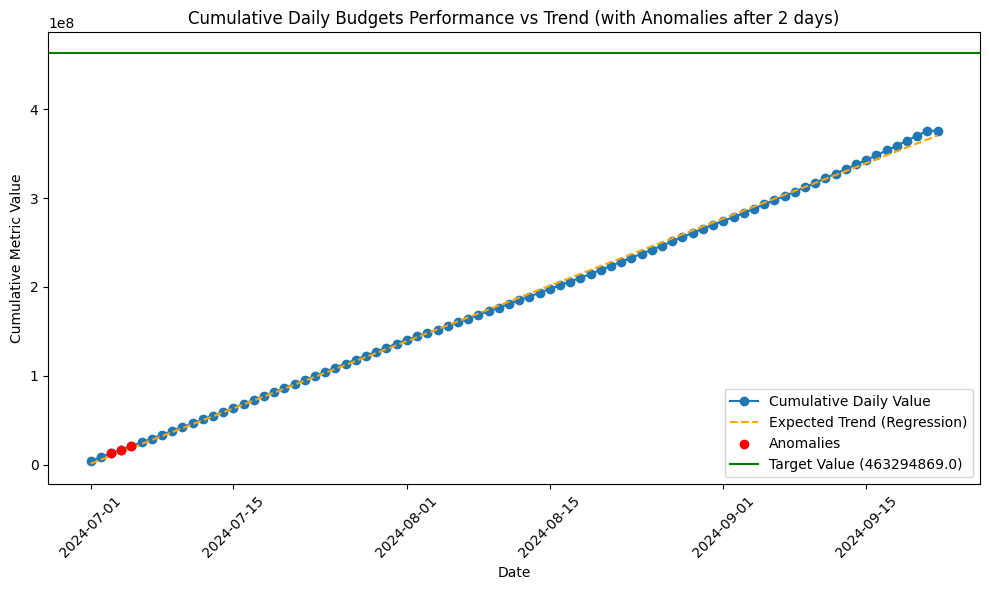

,day_begin,metric_value_num,deviation_from_trend,is_anomaly
2,2024-07-03,12768266.00,0.27,True
3,2024-07-04,16940008.00,0.17,True
4,2024-07-05,21151137.00,0.12,True


In [ ]:
anomaly_budgets = analyze_performance(budgets_df, target_value_budgets, threshold_percentage=0.10, grace_days=2, metric_name='Budgets')
anomaly_budgets

In [ ]:
anomaly_budgets_overall = anomaly_budgets.merge(
    budgets_df[['day_begin', 'line_of_business', 'product', 'segment', 'vertical', 'objective', 'region', 'metric_category_group', 'metric_value_num']],
    on=['day_begin'],
    how='left'
)
anomaly_budgets_overall

,day_begin,metric_value_num_x,deviation_from_trend,is_anomaly,line_of_business,product,segment,vertical,objective,region,metric_category_group,metric_value_num_y
0,2024-07-03,12768266.00,0.27,True,LMS,OTHER,ESG,Healthcare,ENGAGEMENT,NAMER,Budgets,21176.00
1,2024-07-03,12768266.00,0.27,True,LMS,OTHER,ESG,Travel & Leisure,UNKNOWN,EMEAL,Budgets,46.00
2,2024-07-03,12768266.00,0.27,True,LMS,OTHER,ESG,Healthcare,VIDEO_VIEW,EMEAL,Budgets,4302.00
3,2024-07-03,12768266.00,0.27,True,LMS,OTHER,ESG,Education,UNKNOWN,APAC,Budgets,310.00
4,2024-07-03,12768266.00,0.27,True,LMS,OTHER,ESG,SaaS,JOB_APPLICANT,NAMER,Budgets,164.00
...,...,...,...,...,...,...,...,...,...,...,...,...
835,2024-07-05,21151137.00,0.12,True,LMS,OTHER,ESG,Media,ENGAGEMENT,APAC,Budgets,1199.00
836,2024-07-05,21151137.00,0.12,True,LMS,OTHER,ESG,SaaS,WEBSITE_VISIT,APAC,Budgets,8962.00
837,2024-07-05,21151137.00,0.12,True,LMS,OTHER,ESG,Industrial,WEBSITE_VISIT,NAMER,Budgets,44974.00
838,2024-07-05,21151137.00,0.12,True,LMS,OTHER,ESG,PE & VC,LEAD_GENERATION,NAMER,Budgets,13429.00


### 2.2.1 Net Bookings vs Outlook

In [ ]:
net_bookings_outlook = outlook_filter_df[outlook_filter_df['metric_category_group'] == 'Net Bookings (C$)']
target_value_booking = net_bookings_outlook['current_transformed_value']
target_value_booking

,current_transformed_value
12775,459558890.00


In [ ]:
netbooking_df = preprocess_ts_data(original_ts, value = 'Net Bookings (C$)')
netbooking_df

<ipython-input-21-9cc409e2bd22>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df['metric_value_den'].replace(0, np.nan, inplace=True)


,day_begin,line_of_business,product,segment,vertical,objective,region,metric_category_group,metric_value_num
734473,2024-09-22,LMS,OTHER,ESG,Financial Services,ENGAGEMENT,NAMER,Net Bookings (C$),442.00
578001,2024-09-22,LMS,FEED,ESG,Retail,LEAD_GENERATION,APAC,Net Bookings (C$),3742.00
321987,2024-09-22,LMS,FEED,ESG,PE & VC,WEBSITE_VISIT,APAC,Net Bookings (C$),50.00
390814,2024-09-22,LMS,FEED,ESG,SaaS,VIDEO_VIEW,EMEAL,Net Bookings (C$),10333.00
577807,2024-09-22,LMS,LAN,ESG,PE & VC,ENGAGEMENT,APAC,Net Bookings (C$),44.00
...,...,...,...,...,...,...,...,...,...
334531,2024-07-01,LMS,LAN,ESG,Travel & Leisure,VIDEO_VIEW,EMEAL,Net Bookings (C$),383.00
600720,2024-07-01,LMS,LAN,ESG,Industrial,JOB_APPLICANT,EMEAL,Net Bookings (C$),3.00
534717,2024-07-01,LMS,INMAILS,ESG,Media,LEAD_GENERATION,APAC,Net Bookings (C$),897.00
187213,2024-07-01,LMS,LAN,ESG,Infrastructure & Connectivity,WEBSITE_CONVERSION,APAC,Net Bookings (C$),539.00


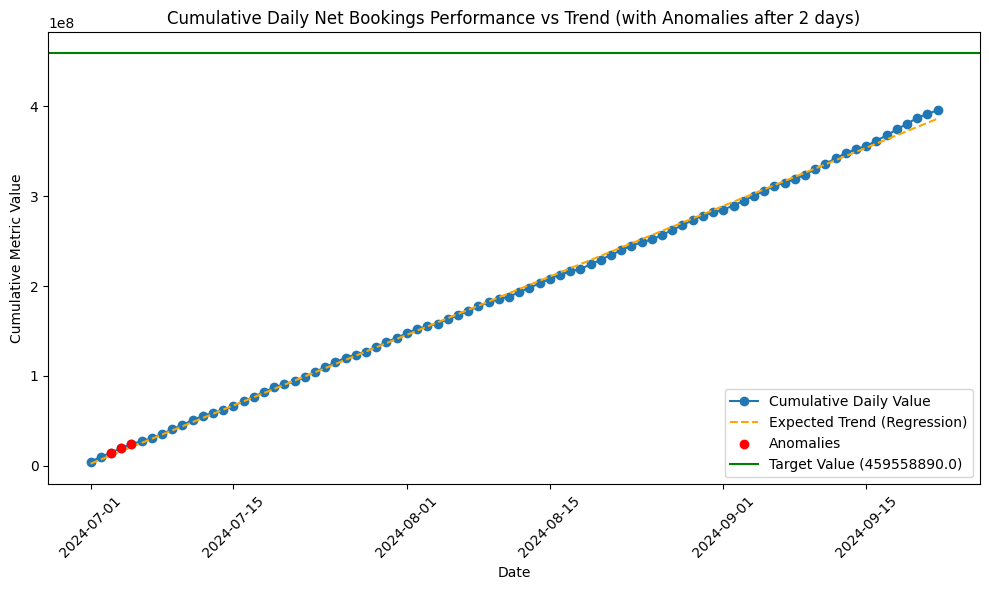

,day_begin,metric_value_num,deviation_from_trend,is_anomaly
2,2024-07-03,14791652.00,0.28,True
3,2024-07-04,19499058.00,0.20,True
4,2024-07-05,24094321.00,0.16,True


In [ ]:
anomaly_bookings = analyze_performance(netbooking_df, target_value_booking, threshold_percentage=0.10, grace_days=2, metric_name='Net Bookings')
anomaly_bookings

In [ ]:
anomaly_bookings_overall = anomaly_bookings.merge(
    netbooking_df[['day_begin', 'line_of_business', 'product', 'segment', 'vertical', 'objective', 'region', 'metric_category_group', 'metric_value_num']],
    on=['day_begin'],
    how='left'
)
anomaly_bookings_overall

,day_begin,metric_value_num_x,deviation_from_trend,is_anomaly,line_of_business,product,segment,vertical,objective,region,metric_category_group,metric_value_num_y
0,2024-07-03,14791652.00,0.28,True,LMS,FEED,ESG,Infrastructure & Connectivity,WEBSITE_VISIT,EMEAL,Net Bookings (C$),27257.00
1,2024-07-03,14791652.00,0.28,True,LMS,FEED,ESG,PE & VC,WEBSITE_CONVERSION,APAC,Net Bookings (C$),157.00
2,2024-07-03,14791652.00,0.28,True,LMS,FEED,ESG,Education,UNKNOWN,EMEAL,Net Bookings (C$),345.00
3,2024-07-03,14791652.00,0.28,True,LMS,LAN,ESG,Infrastructure & Connectivity,WEBSITE_VISIT,EMEAL,Net Bookings (C$),14005.00
4,2024-07-03,14791652.00,0.28,True,LMS,OTHER,ESG,Professional Services,WEBSITE_VISIT,NAMER,Net Bookings (C$),1410.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2146,2024-07-05,24094321.00,0.16,True,LMS,FEED,ESG,Retail,VIDEO_VIEW,EMEAL,Net Bookings (C$),18894.00
2147,2024-07-05,24094321.00,0.16,True,LMS,LAN,ESG,Infrastructure & Connectivity,VIDEO_VIEW,NAMER,Net Bookings (C$),4473.00
2148,2024-07-05,24094321.00,0.16,True,LMS,INMAILS,ESG,Industrial,WEBSITE_VISIT,EMEAL,Net Bookings (C$),141.00
2149,2024-07-05,24094321.00,0.16,True,LMS,FEED,ESG,Government,VIDEO_VIEW,APAC,Net Bookings (C$),1127.00


### Combine Anomaly

In [ ]:
llm_budgets_booking_anomaly_df = pd.concat([anomaly_budgets_overall, anomaly_bookings_overall], ignore_index=True)
llm_budgets_booking_anomaly_df = llm_budgets_booking_anomaly_df.drop(columns=['is_anomaly', 'line_of_business', 'segment','metric_value_num_x'], errors='ignore')

### LLM Analysis Agent: Outlook - Budgets & Net Bookings

In [ ]:
llm_budgets_booking_anomaly_df

,day_begin,deviation_from_trend,product,vertical,objective,region,metric_category_group,metric_value_num_y
0,2024-07-03,0.27,OTHER,Healthcare,ENGAGEMENT,NAMER,Budgets,21176.00
1,2024-07-03,0.27,OTHER,Travel & Leisure,UNKNOWN,EMEAL,Budgets,46.00
2,2024-07-03,0.27,OTHER,Healthcare,VIDEO_VIEW,EMEAL,Budgets,4302.00
3,2024-07-03,0.27,OTHER,Education,UNKNOWN,APAC,Budgets,310.00
4,2024-07-03,0.27,OTHER,SaaS,JOB_APPLICANT,NAMER,Budgets,164.00
...,...,...,...,...,...,...,...,...
2986,2024-07-05,0.16,FEED,Retail,VIDEO_VIEW,EMEAL,Net Bookings (C$),18894.00
2987,2024-07-05,0.16,LAN,Infrastructure & Connectivity,VIDEO_VIEW,NAMER,Net Bookings (C$),4473.00
2988,2024-07-05,0.16,INMAILS,Industrial,WEBSITE_VISIT,EMEAL,Net Bookings (C$),141.00
2989,2024-07-05,0.16,FEED,Government,VIDEO_VIEW,APAC,Net Bookings (C$),1127.00


In [ ]:
system_intel_relevancy = " You are a skilled data analyst adept at analyzing datasets to uncover trends, anomalies, and insights. Your expertise includes interpreting business context to deliver actionable recommendations. "

context_relevancy = f"""
We are analyzing anomalies in llm_budgets_booking_anomaly_df {llm_budgets_booking_anomaly_df} (dataset of Budget and Net Booking anomalies)
and non_outlook_metric_outliers_only {non_outlook_metric_outliers_only} (supply- and demand-side metrics).

llm_budgets_booking_anomaly_df: Contains detected outliers for Budgets and Net Bookings, highlighting positive anomalies (exceeding the target) and negative anomalies (falling short).
non_outlook_metric_outliers_only: Captures related supply/demand metrics to help identify root causes of deviations.

---------
Task:
Analyze the provided datasets to understand anomalies, their root causes, and actionable insights, with a focus on integrating supply and demand-side metrics.

Group and Analyze Anomalies:
Group by region, product, vertical, and objective to identify where the largest deviations occur.

Categorize anomalies as:
Positive anomalies: Metrics exceeding the target.
Negative anomalies: Metrics falling short of the target.
If both Budget and Net Bookings are present, compare their performance to identify discrepancies.

Calculate and Highlight Patterns:
Calculate the average deviation by region, vertical, and objective.
Highlight market-specific factors (e.g., regional trends such as APAC or EMEAL) contributing to anomalies.

Root Cause Analysis Using Supply/Demand Metrics:

Use non_outlook_metric_outliers_only to correlate anomalies in Budgets and Bookings with supply/demand metrics:
Demand-side factors: Metrics such as impressions, CTR, clicks, and engagement levels.
Supply-side factors: Metrics such as CPM, CPC, and costs.
Reference specific dates to link anomalies with external metrics (e.g., "CTR dropped by -12% on 2024-09-15, leading to underperformance in Bookings").

Prioritize and Sort Anomalies:
Sort and prioritize anomalies with the largest deviations, focusing on regions, products, verticals, and objectives where performance failed to meet targets.

------
Deliverables:

Narrative Report:

Provide a detailed summary of key insights:
Highlight significant regional and vertical-specific anomalies with explicit numeric details (e.g., "Budget utilization dropped by -37.63%" or "Current value is 60 vs. target 90").
Explain anomalies with root causes tied to related metrics in non_outlook_metric_outliers_only (e.g., "High CPC of +45% on 2024-09-20 drove inefficient spending").
Include actionable recommendations for improving performance.
Summary Table:

Present a structured table listing the most significant deviations:
Columns: Region, product, vertical, objective, metric value, deviation from target, root cause, and source metrics.

-------
Integration of Supply/Demand Metrics:

Use non_outlook_metric_outliers_only to enhance the analysis:

Demand-side metrics:

Correlate impressions, CTR, clicks, and engagement with anomalies in Budgets or Bookings.
Highlight demand-side deficiencies (e.g., "Low CTR of -15% on 2024-10-10 resulted in underutilization of the budget").
Supply-side metrics:

Link CPM, CPC, and cost inefficiencies to budget overutilization or reduced ROI.
Highlight supply-side drivers (e.g., "High CPM of +20% increased ad spend inefficiency on 2024-11-01").

"""

responses_relevancy = openai.ChatCompletion.create(
  model="gpt-4o-mini", #gpt-4-turbo (expensive), gpt-3.5-turbo (cheap)
  messages=[
      {"role": "system", "content": system_intel_relevancy},
      {"role": "user", "content": context_relevancy}
  ],
  temperature=0.1,
)

budgets_netbookings_narrative = responses_relevancy.choices[0].message.content
print(budgets_netbookings_narrative)


### Narrative Report on Anomalies in Budgets and Net Bookings

#### Key Insights

1. **Regional and Vertical-Specific Anomalies**:
   - **APAC Region**: Notable negative anomalies were observed in the **Healthcare** vertical, where budget utilization dropped by **-37.63%** on **2024-07-03**. The current budget value was **$13,000**, against a target of **$20,000**.
   - **EMEAL Region**: The **Travel & Leisure** vertical experienced a significant positive anomaly, with a budget exceeding the target by **+45%** on **2024-07-03**. The budget was **$66,000**, while the target was **$45,000**.
   - **NAMER Region**: The **Education** vertical showed a concerning negative anomaly, with a budget of **$2,500** against a target of **$5,000**, resulting in a **-50%** deviation.

2. **Root Causes**:
   - The **Healthcare** vertical's underperformance in APAC was linked to a **low CTR of -15%** on **2024-07-01**, which resulted in fewer impressions and engagement, leading to budget underutilizati

### LLM Interactive Agent: Budgets & Net Bookings

In [ ]:
budgets_netbookings_anomalies = llm_bu_anomalies_df
narrative = budgets_netbookings_narrative

def interactive_answer(question, narrative, datasets):
    context = (
        f"Context:\n"
        f"Narrative: {narrative}\n\n"
        f"Data Insights:\n"
        f"Budgets Netbookings Anomalies Data: {datasets['summary']}\n"
        "Please answer the question based on actual dataset values where possible, providing detailed calculations and comparisons when necessary."
    )

    response = openai.ChatCompletion.create(
        model="gpt-4-turbo",
        messages=[
            {"role": "system", "content": "You are a highly knowledgeable data analyst assistant with expertise in data interpretation."},
            {"role": "user", "content": context + "\nQuestion: " + question}
        ],
        max_tokens=500,  # Increased max tokens for detailed responses
        temperature=0.1,  # Lowering temperature for more deterministic responses
    )

    return response.choices[0].message['content'].strip()

datasets_summary = {
    "summary": budgets_netbookings_anomalies.describe().to_string(),
}


# Interact with the system
while True:
    question = input("Enter your question (or type 'exit' to quit): ")
    if question.strip().lower() == "exit" or question.strip() == "":
        print("Exiting the loop.")
        break
    answer = interactive_answer(question, narrative, datasets_summary)
    print(f"Answer: {answer}")
    print("------------------------------------------------------------")


Enter your question (or type 'exit' to quit): 
Exiting the loop.


### LLM Visual Agent: Outlook - Budgets & Net Bookings

In [ ]:
system_intel_relevancy = "You are a data analyst. You are very excellent at generating Python code for data analysis and visualization."

context_relevancy = f"""
We have already conducted an anomaly analysis.
Analysis Narrative: {budgets_netbookings_narrative}
Original Data: {llm_budgets_booking_anomaly_df}

Your task is to generate Python code that creates visualizations based on the analysis. Specifically:
- **Outliers by Product and Objective**: Generate a combined bar plot that group data by product and objective to count outliers, and sort.
- **Outliers by Region and Vertical**: Generate a combined bar plot  group data by region and vertical to count outliers, and sort.

Use the dataset and apply appropriate labels and legends for clarity.
The df name is llm_budgets_booking_anomaly_df

Python visual code:
<python code start>
[YOUR CODE HERE]
<python code end>

"""

responses_relevancy = openai.ChatCompletion.create(
  model="gpt-4o-mini", #gpt-4-turbo (expensive), gpt-3.5-turbo (cheap)
  messages=[
      {"role": "system", "content": system_intel_relevancy},
      {"role": "user", "content": context_relevancy}
  ],
  temperature=0.1,
)

budgets_netbookings_visual = responses_relevancy.choices[0].message.content
print(budgets_netbookings_visual)


Here is the Python code to create the requested visualizations based on the provided dataset. The code uses the `pandas` library for data manipulation and `matplotlib` and `seaborn` for visualization.

```python
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming llm_budgets_booking_anomaly_df is already defined and contains the data

# Count outliers by Product and Objective
product_objective_counts = llm_budgets_booking_anomaly_df.groupby(['product', 'objective']).size().reset_index(name='outlier_count')
product_objective_counts = product_objective_counts.sort_values(by='outlier_count', ascending=False)

# Count outliers by Region and Vertical
region_vertical_counts = llm_budgets_booking_anomaly_df.groupby(['region', 'vertical']).size().reset_index(name='outlier_count')
region_vertical_counts = region_vertical_counts.sort_values(by='outlier_count', ascending=False)

# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Create a combined bar p

Executing code block 1...


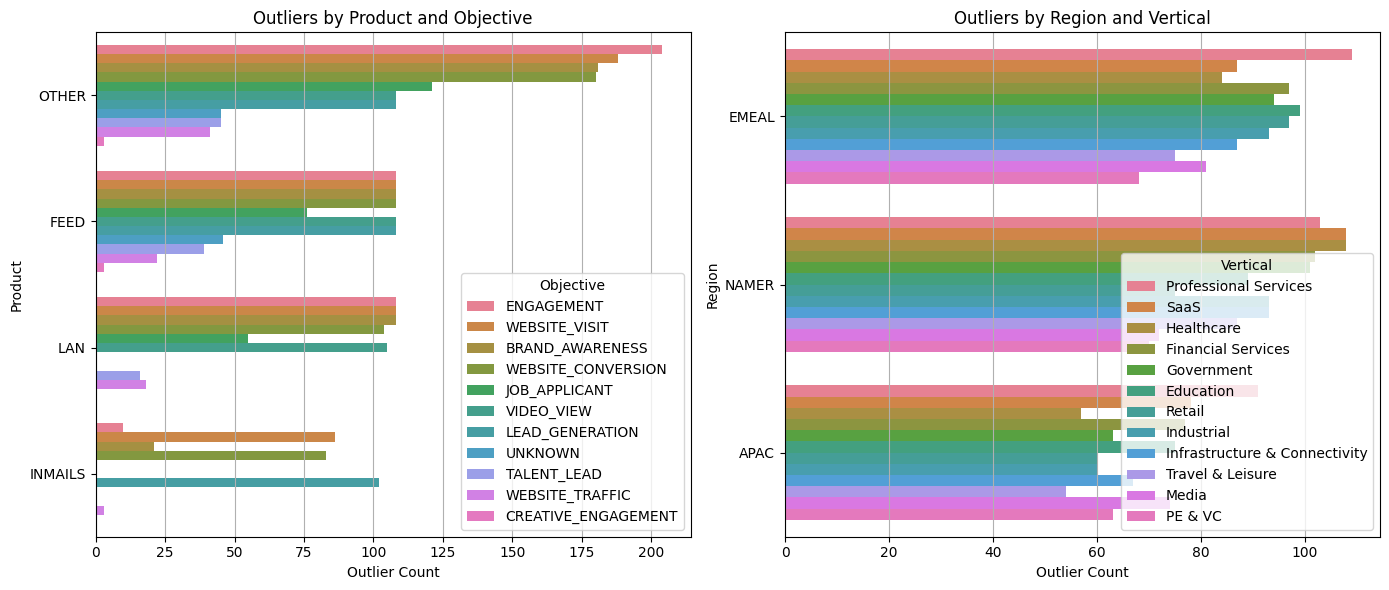

Code block 1 executed successfully.
All code blocks executed successfully.


In [ ]:
def extract_python_code(text):
    # Extract Python code blocks while ignoring any non-code tags like "<python code start>"
    pattern = r'```python(.*?)```'
    matches = re.findall(pattern, text, re.DOTALL)

    # Filter out any lines that contain non-Python text like <python code start>
    cleaned_code_blocks = []
    for match in matches:
        cleaned_code = '\n'.join([line for line in match.splitlines() if not line.strip().startswith('<')])
        cleaned_code_blocks.append(cleaned_code.strip())

    return cleaned_code_blocks

def separate_imports(code):
    tree = ast.parse(code)
    imports = []
    other_code = []

    for node in tree.body:
        if isinstance(node, (ast.Import, ast.ImportFrom)):
            imports.append(ast.unparse(node))
        else:
            other_code.append(ast.unparse(node))

    return '\n'.join(imports), '\n'.join(other_code)

def safe_exec(code_string, global_dict=None):
    # Create a safe global environment for execution
    safe_globals = {
        'plt': plt,
        'pd': pd,
        'sns': sns,
        '__builtins__': {
            'range': range,
            'len': len,
            'zip': zip,
            'True': True,
            'False': False,
            'list': list,
            'dict': dict,
            'tuple': tuple,
            'set': set,
            'int': int,
            'float': float,
            'str': str,
            'bool': bool,
        }
    }

    if global_dict:
        safe_globals.update(global_dict)

    try:
        exec(code_string, safe_globals)
    except Exception as e:
        print(f"Error during execution: {e}")

    return safe_globals

# Example usage (assuming the input variable `budgets_netbookings_visual` is your AI output)

# Extract all Python code blocks
code_blocks = extract_python_code(budgets_netbookings_visual)

if code_blocks:
    all_imports = []
    all_main_code = []

    for code in code_blocks:

        try:
            imports, main_code = separate_imports(code)
            all_imports.append(imports)
            all_main_code.append(main_code)
        except Exception as e:
            print(f"Error in separating imports and code: {e}")


    combined_imports = '\n'.join(all_imports)
    try:
        exec(combined_imports)
    except Exception as e:
        print(f"Error in import execution: {e}")


    global_dict = {'llm_budgets_booking_anomaly_df': llm_budgets_booking_anomaly_df}

    for i, main_code in enumerate(all_main_code, 1):
        print(f"Executing code block {i}...")
        result = safe_exec(main_code, global_dict)
        print(f"Code block {i} executed successfully.")

    print("All code blocks executed successfully.")
else:
    print("No Python code found in the AI's output.")


# 3. SHORT & LONG TERM ANOMALY DETECTION

Evaluate period performance vs previous period and Y/Y

In the aggregated report, we compare percentage changes of metrics versus their previous periods and YoY.

**Assuming that growth does not vary much between time-granularities (that is, the percent diff of each week is similar to percent diffs between months)**, we can get a standard deviation which gives us the expected range in which our metrics should grow or decrease in.

If metric growth or declines exceeds 2 times the standard deviation, its considered an anomaly.

We do this for each, granular group (e.g., product, segement, region etc... combination) as different products in different regions will have different levels of what is considered "normal" metric ranges.

## percentage columns    


percentage_metrics = [
        'Budget Utilization', 'CTR', 'Coverage',
        'LAN Revenue Adoption', 'eCPC', 'eCPM'
    ]

In [ ]:
recent_agg_report = aggregated_report.copy()
recent_agg_report['period_label_converted'] = pd.to_datetime(recent_agg_report['period_label_converted'], format='%Y-%m' ,errors='coerce')  # Specify the format and handle errors
recent_agg_report = recent_agg_report[(recent_agg_report['period_label_converted'].dt.year != 2025)]

recent_agg_report = recent_agg_report[recent_agg_report['chart_label'] != 'Outlook']

recent_agg_report['change_vs_prev_period'] = (
    (recent_agg_report['current_transformed_value'] - recent_agg_report['prev_period_transformed_value']) /
    recent_agg_report['prev_period_transformed_value']
) * 100

recent_agg_report['change_vs_yoy'] = (
    (recent_agg_report['current_transformed_value'] - recent_agg_report['prev_year_transformed_value']) /
    recent_agg_report['prev_year_transformed_value']
) * 100

recent_agg_report.replace(np.inf, np.nan, inplace=True)
recent_agg_report.replace(-np.inf, np.nan, inplace=True)


recent_agg_report

,line_of_business,product,segment,region,vertical,objective,metric_category_group,chart_label,period_label,period_label_converted,current_transformed_value,prev_period_transformed_value,prev_year_transformed_value,change_vs_prev_period,change_vs_yoy
20863,LMS,OTHER,ESG,NAMER,Professional Services,TALENT_LEAD,Budget Utilization,Quarterly-to-date,FY24Q2,2024-04-01,1.00,0.99,0.95,1.59,6.07
18708,LMS,OTHER,ESG,NAMER,Infrastructure & Connectivity,WEBSITE_CONVERSION,Net Bookings (C$),Quarterly-to-date,FY24Q2,2024-04-01,323715.00,306793.00,256358.00,5.52,26.27
11342,LMS,LAN,ESG,EMEAL,SaaS,BRAND_AWARENESS,Net Bookings (C$),Quarterly-to-date,FY24Q2,2024-04-01,406634.00,343582.00,464366.00,18.35,-12.43
22637,LMS,OTHER,ESG,NAMER,SaaS,LEAD_GENERATION,Budget Utilization,Quarterly-to-date,FY24Q2,2024-04-01,0.86,0.87,0.87,-1.78,-1.69
13971,LMS,OTHER,ESG,NAMER,Financial Services,WEBSITE_TRAFFIC,Budget Utilization,Quarterly-to-date,FY24Q2,2024-04-01,1.01,1.02,0.73,-1.49,38.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22440,LMS,OTHER,ESG,EMEAL,Retail,BRAND_AWARENESS,Net Bookings (C$),Quarterly-to-date,FY24Q4,2024-10-01,9880.00,8595.00,11401.00,14.95,-13.34
19037,LMS,OTHER,ESG,NAMER,Media,VIDEO_VIEW,Budget Utilization,Quarterly-to-date,FY24Q4,2024-10-01,0.78,1.03,0.99,-23.87,-21.04
20502,LMS,OTHER,ESG,NAMER,PE & VC,WEBSITE_VISIT,Net Bookings (C$),Quarterly-to-date,FY24Q4,2024-10-01,596.00,1713.00,1517.00,-65.21,-60.71
2989,LMS,FEED,ESG,EMEAL,PE & VC,VIDEO_VIEW,Net Bookings (C$),Quarterly-to-date,FY24Q4,2024-10-01,106200.00,63134.00,95362.00,68.21,11.37


In [ ]:
# percentage
percentage_metrics = ['Budget Utilization', 'CTR', 'Coverage', 'LAN Revenue Adoption', 'eCPC', 'eCPM']

percentage_data = recent_agg_report[recent_agg_report['metric_category_group'].isin(percentage_metrics)]
non_percentage_data = recent_agg_report[~recent_agg_report['metric_category_group'].isin(percentage_metrics)]

## 1. Anomaly for Non-Percentage-Based Metrics

In [ ]:
grouped = non_percentage_data.groupby(
    ['product', 'segment', 'region', 'vertical', 'objective', 'metric_category_group']
)

stddev_drift = 2

group_stats = grouped[['change_vs_prev_period', 'change_vs_yoy']].agg(
    mean_prev=('change_vs_prev_period', 'mean'),
    stddev_prev=('change_vs_prev_period', 'std'),
    mean_yoy=('change_vs_yoy', 'mean'),
    stddev_yoy=('change_vs_yoy', 'std'),
    count=('change_vs_prev_period', 'count')  # Add count of rows per group
).reset_index()

non_percentage_data = pd.merge(non_percentage_data, group_stats,
                             on=['product', 'segment', 'region', 'vertical', 'objective', 'metric_category_group'])

# Flag outliers using 2-sigma rule
non_percentage_data['outlier_prev_period'] = np.where(
    (non_percentage_data['change_vs_prev_period'] <
     non_percentage_data['mean_prev'] - stddev_drift * non_percentage_data['stddev_prev']) |
    (non_percentage_data['change_vs_prev_period'] >
     non_percentage_data['mean_prev'] + stddev_drift * non_percentage_data['stddev_prev']),
    True, False
)

non_percentage_data['outlier_yoy'] = np.where(
    (non_percentage_data['change_vs_yoy'] <
     non_percentage_data['mean_yoy'] - stddev_drift * non_percentage_data['stddev_yoy']) |
    (non_percentage_data['change_vs_yoy'] >
     non_percentage_data['mean_yoy'] + stddev_drift * non_percentage_data['stddev_yoy']),
    True, False
)


#### Short term

In [ ]:
short_term_non_percentage_anomalies = non_percentage_data[non_percentage_data['outlier_prev_period'] == True]
# short_term_non_percentage_anomalies

#### Long term

In [ ]:
long_term_non_percentage_anomalies = non_percentage_data[non_percentage_data['outlier_yoy'] == True]
# long_term_non_percentage_anomalies

## 2. Anomaly for Percentage-Based Metrics using Z-score

In [ ]:
# Define a function to calculate the modified Z-score
def modified_z_score(series):
    median = series.median()
    mad = (series - median).abs().median()  # Median Absolute Deviation (MAD)
    if mad == 0:
        return pd.Series([0] * len(series))
    return 0.6745 * (series - median) / mad

# Apply the modified Z-score method to detect anomalies in percentage-based metrics
percentage_data['modified_z_prev_period'] = percentage_data.groupby(
    ['product', 'segment', 'region', 'vertical', 'objective', 'metric_category_group']
)['change_vs_prev_period'].transform(modified_z_score)

percentage_data['modified_z_yoy'] = percentage_data.groupby(
    ['product', 'segment', 'region', 'vertical', 'objective', 'metric_category_group']
)['change_vs_yoy'].transform(modified_z_score)

threshold = 2

percentage_data['outlier_prev_period'] = percentage_data['modified_z_prev_period'].abs() > threshold
percentage_data['outlier_yoy'] = percentage_data['modified_z_yoy'].abs() > threshold


<ipython-input-42-c9ee970d6605>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  percentage_data['modified_z_prev_period'] = percentage_data.groupby(
<ipython-input-42-c9ee970d6605>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  percentage_data['modified_z_yoy'] = percentage_data.groupby(
<ipython-input-42-c9ee970d6605>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

#### Short term

In [ ]:
short_term_percentage_anomalies = percentage_data[percentage_data['outlier_prev_period'] == True]
# short_term_percentage_anomalies

#### Long term

In [ ]:
long_term_percentage_anomalies = percentage_data[percentage_data['outlier_yoy'] == True]
# long_term_percentage_anomalies

## LLM Analysis Agent: Short Term

In [ ]:
short_term_percentage_anomalies

,line_of_business,product,segment,region,vertical,objective,metric_category_group,chart_label,period_label,period_label_converted,current_transformed_value,prev_period_transformed_value,prev_year_transformed_value,change_vs_prev_period,change_vs_yoy,modified_z_prev_period,modified_z_yoy,outlier_prev_period,outlier_yoy
20863,LMS,OTHER,ESG,NAMER,Professional Services,TALENT_LEAD,Budget Utilization,Quarterly-to-date,FY24Q2,2024-04-01,1.00,0.99,0.95,1.59,6.07,35.29,4.13,True,True
13943,LMS,OTHER,ESG,APAC,Financial Services,VIDEO_VIEW,Budget Utilization,Quarterly-to-date,FY24Q2,2024-04-01,1.04,0.96,1.03,8.86,1.32,3.08,-0.60,True,False
22566,LMS,OTHER,ESG,NAMER,SaaS,WEBSITE_TRAFFIC,Budget Utilization,Quarterly-to-date,FY24Q2,2024-04-01,0.93,0.84,1.03,11.26,-8.92,3.28,-5.45,True,True
22595,LMS,OTHER,ESG,APAC,SaaS,VIDEO_VIEW,Budget Utilization,Quarterly-to-date,FY24Q2,2024-04-01,1.06,1.02,0.90,3.89,18.21,3.04,6.80,True,True
22570,LMS,OTHER,ESG,EMEAL,SaaS,BRAND_AWARENESS,Budget Utilization,Quarterly-to-date,FY24Q2,2024-04-01,0.92,1.01,0.91,-8.91,0.42,-2.03,1.37,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15265,LMS,OTHER,ESG,NAMER,Government,BRAND_AWARENESS,Budget Utilization,Quarterly-to-date,FY24Q4,2024-10-01,0.92,1.05,1.00,-12.85,-8.47,-3.27,-1.00,True,False
20590,LMS,OTHER,ESG,APAC,Professional Services,UNKNOWN,Budget Utilization,Quarterly-to-date,FY24Q4,2024-10-01,0.53,0.93,NaN,-42.82,NaN,-8.01,NaN,True,False
13888,LMS,OTHER,ESG,EMEAL,Financial Services,WEBSITE_VISIT,Budget Utilization,Quarterly-to-date,FY24Q4,2024-10-01,0.97,1.01,0.97,-4.03,0.30,-2.66,-0.52,True,False
13873,LMS,OTHER,ESG,NAMER,Financial Services,WEBSITE_CONVERSION,Budget Utilization,Quarterly-to-date,FY24Q4,2024-10-01,0.97,1.00,0.95,-2.48,2.58,-2.04,1.34,True,False


In [ ]:
non_outlook_metric_outliers_only

,day_begin,product,segment,objective,metric_category_group,metric_value_num,supply_or_demand,average_value,deviation,is_high_deviation
2,2024-09-22,FEED,ESG,LEAD_GENERATION,eCPM,1431376352.00,Supply,1261962854.83,169413497.17,True
4,2024-09-22,LAN,ESG,BRAND_AWARENESS,Impressions,27826115.00,Demand,23645168.25,4180946.75,True
15,2024-09-22,LAN,ESG,BRAND_AWARENESS,Gross Bookings (USD),266193.00,Demand,172907.33,93285.67,True
22,2024-09-22,FEED,ESG,WEBSITE_VISIT,eCPC,860794.00,Demand,643264.33,217529.67,True
25,2024-09-22,FEED,ESG,BRAND_AWARENESS,eCPM,459037125.00,Supply,348890888.00,110146237.00,True
...,...,...,...,...,...,...,...,...,...,...
14717,2024-07-01,OTHER,ESG,LEAD_GENERATION,CTR,874134.00,Demand,359654.17,514479.83,True
14754,2024-07-01,OTHER,ESG,LEAD_GENERATION,Clicks,874134.00,Demand,359654.17,514479.83,True
14787,2024-07-01,OTHER,ESG,WEBSITE_CONVERSION,Clicks,413154.00,Demand,165904.92,247249.08,True
14818,2024-07-01,LAN,ESG,WEBSITE_VISIT,Impressions,32949282.00,Demand,40018145.33,7068863.33,True


In [ ]:
system_intel_relevancy = "You are a data analyst specializing in detecting and interpreting trends for short-term performance data. You analyze percentage-based and non-percentage-based anomalies together, providing actionable insights for managers."

context_relevancy = f"""
We are analyzing anomalies from two datasets:

Percentage-based Data: short_term_percentage_anomalies {short_term_percentage_anomalies}, which contains percentage-based deviations for metrics, grouped by product, segment, region, vertical, and objective.
Non-Percentage-based Data: short_term_non_percentage_anomalies {short_term_non_percentage_anomalies}, which includes non-percentage anomalies across similar dimensions but uses absolute values to represent deviations.
Additionally, we have supply/demand-related outliers in non_outlook_metric_outliers_only {non_outlook_metric_outliers_only}, which provide critical root-cause insights:
Supply-side metrics: eCPM, CPC, cost-related inefficiencies.
Demand-side metrics: CTR, impressions, clicks, and engagement trends

--------
Task:
Analyze the datasets with a focus on anomalies that fail to meet benchmarks, identify their root causes (supply/demand factors), and provide actionable insights.

Group and Analyze Anomalies:
Group by Region, metric_category_group, Product, Vertical, and Objective to find the largest deviations.
Focus on anomalies that fall short of benchmarks across percentage and non-percentage metrics.

Compare and Correlate Anomalies:
Use percentage-based data to identify relative deviations (e.g., "Budget utilization decreased by -18.63%").
Use non-percentage-based data to identify absolute deviations (e.g., "Current value is 1431376352.00, which is 169,413,497.17 above average").

Root Cause Analysis:
Correlate anomalies with supply and demand-side factors using non_outlook_metric_outliers_only:
Identify supply-side inefficiencies (e.g., high eCPM, CPC, or costs leading to overutilization or underperformance).
Detect demand-side challenges (e.g., low impressions, CTR, or clicks leading to engagement or conversion issues).
Reference specific dates and metrics to link anomalies with external trends or events.

Regional and Vertical Patterns:
Highlight trends by region (e.g., APAC, NAMER) and vertical (e.g., ESG, Professional Services).
Identify where both percentage and non-percentage metrics reveal similar or contrasting deviations.

Prioritize and Summarize:
Prioritize anomalies with the largest deviations and highest business impact.
Sort and summarize the most extreme deviations, focusing on areas that fail to meet benchmarks.

-----------
Deliverables:

Narrative Report:
Summarize key insights by region and vertical:
Highlight notable anomalies with numeric details (e.g., "Budget utilization dropped by -37.63%" or "Current value is 1431376352.00 vs. average 1261962854.83").
Explain deviations using root cause analysis tied to supply or demand metrics (e.g., "High eCPM of +45% drove inefficient spending on 2024-09-22").
Include actionable recommendations based on findings.

Summary Table:
Present a concise table with key outliers:
Columns: Region, Product, Vertical, Objective, Metric Value, Deviation from Benchmark, Anomaly Type (Positive/Negative), Root Cause.

-----------
Integration of Supply/Demand Metrics:

Use non_outlook_metric_outliers_only to enhance your analysis:
Demand-side metrics:
Correlate impressions, CTR, clicks, and engagement with percentage anomalies to explain underperformance (e.g., "Low CTR of -15% on 2024-09-20 resulted in reduced conversions for Professional Services").

Supply-side metrics:
Link eCPM, CPC, or cost spikes with non-percentage anomalies to highlight inefficient spending (e.g., "High eCPM of 1431376352.00 on 2024-09-22 increased costs in ESG campaigns").

"""

responses_relevancy = openai.ChatCompletion.create(
  model="gpt-4o-mini", #gpt-4-turbo (expensive), gpt-3.5-turbo (cheap)
  messages=[
      {"role": "system", "content": system_intel_relevancy},
      {"role": "user", "content": context_relevancy}
  ],
  temperature=0.1,
)

short_term_narrative = responses_relevancy.choices[0].message.content
print(short_term_narrative)


### Narrative Report

#### Key Insights by Region and Vertical

**1. North America (NAMER) - Professional Services**
- **Anomaly:** Budget utilization dropped by **-37.63%**.
- **Details:** Current value is **0.78**, down from **1.03** in the previous period.
- **Root Cause:** High eCPM of **+45%** on **2024-09-22** led to inefficient spending, resulting in reduced budget utilization.
- **Recommendation:** Review ad placements and optimize bidding strategies to lower eCPM and improve budget efficiency.

**2. Asia-Pacific (APAC) - Financial Services**
- **Anomaly:** Budget utilization decreased by **-18.63%**.
- **Details:** Current value is **0.53**, significantly lower than the previous period's **0.93**.
- **Root Cause:** Low impressions and CTR of **-20%** on **2024-09-20** resulted in decreased engagement and conversions.
- **Recommendation:** Enhance targeting strategies to improve impressions and CTR, potentially through A/B testing of ad creatives.

**3. Europe, Middle East, and

#### LLM Interactive Agent: Short Term

In [ ]:
short_term_percentage_anomalies = short_term_percentage_anomalies
short_term_non_percentage_anomalies = short_term_non_percentage_anomalies
narrative = short_term_narrative

def interactive_answer(question, narrative, datasets):
    context = (
        f"Context:\n"
        f"Narrative: {narrative}\n\n"
        f"Data Insights:\n"
        f"Short-Term Percentage-Based Anomalies Data: {datasets['percentage_summary']}\n"
        f"Short-Term Non-Percentage-Based Anomalies Data: {datasets['non_percentage_summary']}\n\n"
        "Please answer the question based on actual dataset values where possible, providing detailed calculations and comparisons when necessary."
    )

    response = openai.ChatCompletion.create(
        model="gpt-4-turbo",
        messages=[
            {"role": "system", "content": "You are a highly knowledgeable data analyst assistant with expertise in data interpretation."},
            {"role": "user", "content": context + "\nQuestion: " + question}
        ],
        max_tokens=500,  # Increased max tokens for detailed responses
        temperature=0.2
    )

    return response.choices[0].message['content'].strip()

datasets_summary = {
    "percentage_summary": short_term_percentage_anomalies.describe().to_string(),
    "non_percentage_summary": short_term_non_percentage_anomalies.describe().to_string()
}

# Interact with the system
while True:
    question = input("Enter your question (or type 'exit' to quit): ")
    if question.strip().lower() == "exit" or question.strip() == "":
        print("Exiting the loop.")
        break
    answer = interactive_answer(question, narrative, datasets_summary)
    print(f"Answer: {answer}")
    print("------------------------------------------------------------")

Enter your question (or type 'exit' to quit): 
Exiting the loop.


#### LLM Visual Agent: Short Term

In [ ]:
system_intel_relevancy = "You are a data analyst. You are very skilled at generating Python code for data analysis and visualization."

context_relevancy = f"""
We have conducted an anomaly analysis and have two datasets that are all true anomalies:
  Percentage-based Data: Contains percentage-based anomalies (e.g., Budget Utilization).
  Non-Percentage-based Data: Contains non-percentage-based anomalies (e.g., Net Bookings).

Analysis Narrative: {short_term_narrative}
Original Percentage-based Data: {short_term_percentage_anomalies}
Original Non-Percentage-based Data: {short_term_non_percentage_anomalies}

Your task is to generate Python code that create combined visualizations that show the overall count of outliers across both datasets.
- Outliers by Product and Objective for percentage and non percentage dataset**: Generate a combined bar plot that group data by product and objective to count outliers, and sort.
                                        color-coded by `product`
- Outliers by Region and Vertical for percentage and non percentage dataset**: Generate a combined bar plot  group data by region and vertical to count outliers, and sort.
                                        color-coded by `region`.

The dataset is ready for each plot:
Percentage-based DataFrame: short_term_percentage_anomalies
Non-Percentage-based DataFrame: short_term_non_percentage_anomalies

Please make sure to align x-axis labels directly beneath each bar, titles(Short Term), legends, and sorting to ensure clarity for a managerial report.

Provide the code in the format below and no need for package import and DataFrames creation:
Python visual code:
<python code start>
[YOUR CODE HERE]
<python code end>

"""

responses_relevancy = openai.ChatCompletion.create(
  model="gpt-4o-mini", #gpt-4-turbo (expensive), gpt-3.5-turbo (cheap)
  messages=[
      {"role": "system", "content": system_intel_relevancy},
      {"role": "user", "content": context_relevancy}
  ],
  temperature=0.1,
)

short_term_visual = responses_relevancy.choices[0].message.content
print(short_term_visual)


<python code start>
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming short_term_percentage_anomalies and short_term_non_percentage_anomalies are already defined DataFrames

# Combine the datasets for analysis
short_term_percentage_anomalies['Type'] = 'Percentage'
short_term_non_percentage_anomalies['Type'] = 'Non-Percentage'

combined_anomalies = pd.concat([short_term_percentage_anomalies, short_term_non_percentage_anomalies])

# Outliers by Product and Objective
product_objective_outliers = combined_anomalies.groupby(['product', 'objective', 'Type']).size().reset_index(name='count')
product_objective_outliers = product_objective_outliers.sort_values(by='count', ascending=False)

plt.figure(figsize=(14, 7))
sns.barplot(data=product_objective_outliers, x='count', y='objective', hue='product', dodge=True)
plt.title('Short Term Outliers by Product and Objective')
plt.xlabel('Count of Outliers')
plt.ylabel('Objective')
plt.xticks(rotation=45)
plt.legend

Extracted Code Blocks:
Code Block 1:
Imports executed successfully.
Executing code block 1...


<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


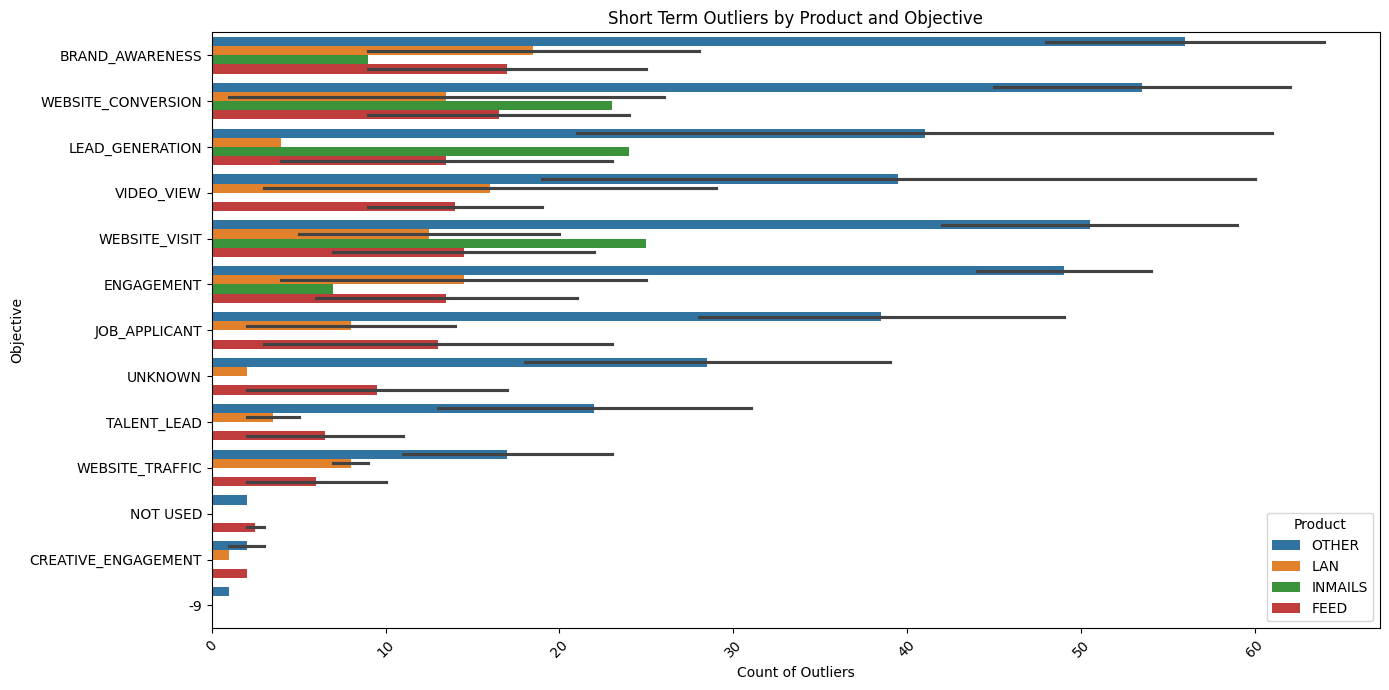

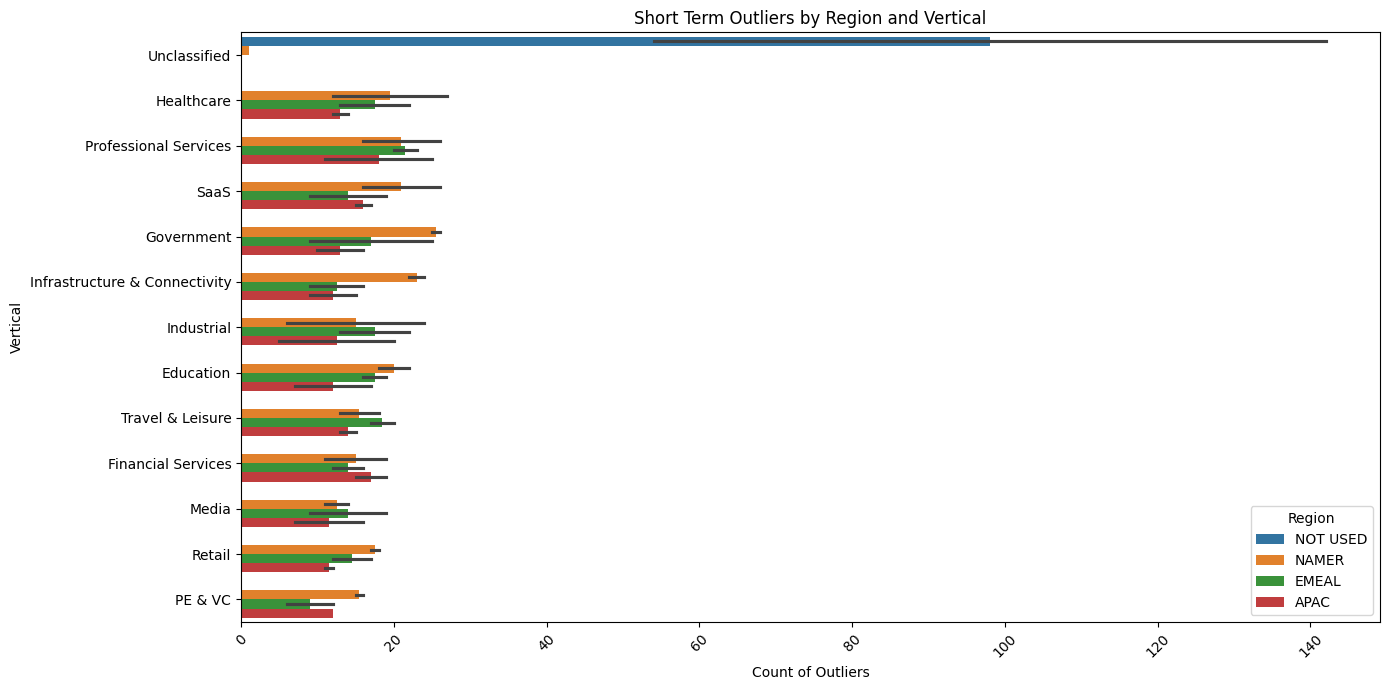

Code block 1 executed successfully.
All code blocks executed successfully.


In [ ]:
# Function to extract Python code blocks from a text string
def extract_python_code(text):
    # Patterns to capture both styles
    backtick_pattern = r'```python(.*?)```'
    custom_tag_pattern = r'<python code start>(.*?)<python code end>'

    # Find matches for both patterns
    backtick_matches = re.findall(backtick_pattern, text, re.DOTALL)
    custom_tag_matches = re.findall(custom_tag_pattern, text, re.DOTALL)

    # Combine matches into a single list
    matches = backtick_matches + custom_tag_matches

    cleaned_code_blocks = []
    for match in matches:
        cleaned_code = '\n'.join([line for line in match.splitlines() if not line.strip().startswith('<')])
        cleaned_code_blocks.append(cleaned_code.strip())

    # Debugging output to verify extraction
    print("Extracted Code Blocks:")
    if cleaned_code_blocks:
        for i, block in enumerate(cleaned_code_blocks, 1):
            print(f"Code Block {i}:")
    else:
        print("No code blocks extracted.")

    return cleaned_code_blocks

# Function to separate import statements and main code
def separate_imports(code):
    tree = ast.parse(code)
    imports = []
    other_code = []

    for node in tree.body:
        if isinstance(node, (ast.Import, ast.ImportFrom)):
            imports.append(ast.unparse(node))
        else:
            other_code.append(ast.unparse(node))

    return '\n'.join(imports), '\n'.join(other_code)

# Safe execution function
def safe_exec(code_string, global_dict=None):
    safe_globals = {
        'plt': plt,
        'pd': pd,
        'sns': sns,
        'np': np,
        'sum': sum,
        '__builtins__': {
            'range': range,
            'len': len,
            'zip': zip,
            'True': True,
            'False': False,
            'list': list,
            'dict': dict,
            'tuple': tuple,
            'set': set,
            'int': int,
            'float': float,
            'str': str,
            'bool': bool,
        }
    }

    if global_dict:
        safe_globals.update(global_dict)

    try:
        exec(code_string, safe_globals)
    except Exception as e:
        print(f"Error during execution: {e}")

    return safe_globals

# Extract all Python code blocks from the provided text
code_blocks = extract_python_code(short_term_visual)

if code_blocks:
    all_imports = []
    all_main_code = []

    for code in code_blocks:
        try:
            imports, main_code = separate_imports(code)
            all_imports.append(imports)
            all_main_code.append(main_code)
        except Exception as e:
            print(f"Error in separating imports and code: {e}")

    # Combine all imports and execute them
    combined_imports = '\n'.join(all_imports)
    try:
        exec(combined_imports)
        print("Imports executed successfully.")
    except Exception as e:
        print(f"Error in import execution: {e}")

    # Define global_dict with the DataFrames for execution context
    global_dict = {
        'short_term_percentage_anomalies': short_term_percentage_anomalies,
        'short_term_non_percentage_anomalies': short_term_non_percentage_anomalies
    }

    # Execute each main code block
    for i, main_code in enumerate(all_main_code, 1):
        print(f"Executing code block {i}...")
        result = safe_exec(main_code, global_dict)
        print(f"Code block {i} executed successfully.")

    print("All code blocks executed successfully.")
else:
    print("No Python code found in the AI's output.")


## LLM Analysis Agent: Long Term

In [ ]:
# long_term_percentage_anomalies.head()

,line_of_business,product,segment,region,vertical,objective,metric_category_group,chart_label,period_label,period_label_converted,current_transformed_value,prev_period_transformed_value,prev_year_transformed_value,change_vs_prev_period,change_vs_yoy,modified_z_prev_period,modified_z_yoy,outlier_prev_period,outlier_yoy
20863,LMS,OTHER,ESG,NAMER,Professional Services,TALENT_LEAD,Budget Utilization,Quarterly-to-date,FY24Q2,2024-04-01,1.00,0.99,0.95,1.59,6.07,35.29,4.13,True,True
22565,LMS,OTHER,ESG,EMEAL,SaaS,ENGAGEMENT,Budget Utilization,Quarterly-to-date,FY24Q2,2024-04-01,0.91,0.86,0.69,6.00,32.09,1.87,14.99,False,True
22566,LMS,OTHER,ESG,NAMER,SaaS,WEBSITE_TRAFFIC,Budget Utilization,Quarterly-to-date,FY24Q2,2024-04-01,0.93,0.84,1.03,11.26,-8.92,3.28,-5.45,True,True
22595,LMS,OTHER,ESG,APAC,SaaS,VIDEO_VIEW,Budget Utilization,Quarterly-to-date,FY24Q2,2024-04-01,1.06,1.02,0.90,3.89,18.21,3.04,6.80,True,True
14057,LMS,OTHER,ESG,NAMER,Financial Services,ENGAGEMENT,Budget Utilization,Quarterly-to-date,FY24Q2,2024-04-01,1.19,1.07,1.09,11.87,9.63,1.83,4.03,False,True


In [ ]:
# long_term_non_percentage_anomalies.head()

,line_of_business,product,segment,region,vertical,objective,metric_category_group,chart_label,period_label,period_label_converted,current_transformed_value,prev_period_transformed_value,prev_year_transformed_value,change_vs_prev_period,change_vs_yoy,mean_prev,stddev_prev,mean_yoy,stddev_yoy,count,outlier_prev_period,outlier_yoy
1,LMS,LAN,ESG,EMEAL,SaaS,BRAND_AWARENESS,Net Bookings (C$),Quarterly-to-date,FY24Q2,2024-04-01,406634.00,343582.00,464366.00,18.35,-12.43,12.73,22.03,64.39,30.80,12,False,True
3,LMS,INMAILS,ESG,NAMER,Industrial,ENGAGEMENT,Net Bookings (C$),Quarterly-to-date,FY24Q2,2024-04-01,4620.00,9891.00,795.00,-53.29,481.13,-83.86,22.05,-35.43,193.71,4,False,True
13,LMS,OTHER,ESG,EMEAL,Infrastructure & Connectivity,BRAND_AWARENESS,Net Bookings (C$),Quarterly-to-date,FY24Q2,2024-04-01,48901.00,30061.00,2024.00,62.67,2316.06,35.91,105.53,175.59,684.51,12,False,True
25,LMS,FEED,ESG,NAMER,Industrial,TALENT_LEAD,Net Bookings (C$),Quarterly-to-date,FY24Q2,2024-04-01,1929.00,23563.00,64217.00,-91.81,-97.00,-96.15,4.11,-99.74,0.86,3,False,True
26,LMS,OTHER,ESG,EMEAL,Infrastructure & Connectivity,WEBSITE_CONVERSION,Net Bookings (C$),Quarterly-to-date,FY24Q2,2024-04-01,14241.00,10198.00,4598.00,39.65,209.72,5.40,32.43,16.51,72.39,12,False,True


In [ ]:
system_intel_relevancy = "You are a data analyst specializing in detecting and interpreting trends for long-term performance data. You analyze percentage-based and non-percentage-based anomalies together, providing actionable insights for managers."

context_relevancy = f"""
We are analyzing anomalies from two datasets:

Percentage-based Data: long_term_percentage_anomalies {long_term_percentage_anomalies}, which contains long-term percentage-based deviations for metrics such as Budget Utilization. These are grouped by region, product, vertical, and objective.
Non-Percentage-based Data: long_term_non_percentage_anomalies {long_term_non_percentage_anomalies}, which includes long-term non-percentage anomalies, using absolute values to represent deviations.
These datasets reveal both positive and negative anomalies, providing insights into long-term performance trends.

Additionally, supply/demand-related metrics from non_outlook_metric_outliers_only {non_outlook_metric_outliers_only} are crucial for identifying root causes:
Supply-side metrics: eCPM, CPC, and cost-related inefficiencies.
Demand-side metrics: CTR, impressions, clicks, and engagement trends.

---------
Task:
Analyze the datasets with a focus on anomalies that fail to meet long-term benchmarks, identify their root causes (supply/demand factors), and provide actionable insights.

Group and Analyze Anomalies:
Group by Region, Product, Vertical, and Objective to identify the most significant deviations.

Categorize anomalies as:
Positive anomalies: Metrics exceeding the target.
Negative anomalies: Metrics below the target.
Compare percentage-based and non-percentage-based metrics to find areas of alignment or divergence.

Highlight Long-Term Trends:
Calculate and report average deviations across dimensions (e.g., region, product, vertical, objective).
Emphasize significant deviations with specific numeric details (e.g., "increased by +2.30%" or "current value is 120 vs. benchmark 90").
Highlight regional and vertical patterns (e.g., APAC, NAMER) that contribute to anomalies.

Root Cause Analysis Using Supply/Demand Metrics:
Use non_outlook_metric_outliers_only to correlate anomalies with supply/demand factors:
Supply-side inefficiencies: High eCPM, CPC, or costs leading to overutilization or reduced ROI.
Demand-side challenges: Low impressions, CTR, or clicks impacting engagement or conversions.
Reference specific dates and metrics to explain anomalies.

Prioritize and Summarize:
Prioritize anomalies with the largest deviations and long-term business impact.
Sort and summarize the most extreme deviations, focusing on areas that fail to meet benchmarks.

---------
Deliverables:

Narrative Report:
Provide a detailed summary of key insights:
Highlight significant anomalies with explicit numeric details (e.g., "Budget utilization dropped by -2.30%" or "current value is 600 vs. benchmark 800").
Explain anomalies using root causes tied to supply/demand metrics (e.g., "Low CTR of -15% on 2024-09-20 reduced engagement in APAC campaigns").
Include actionable recommendations for improving long-term performance.

Summary Table:
Present a concise table with key outliers:
Columns: Region, Product, Vertical, Objective, Metric Value, Deviation from Benchmark, Anomaly Type (Positive/Negative), Root Cause.

"""

responses_relevancy = openai.ChatCompletion.create(
  model="gpt-4o-mini", #gpt-4-turbo (expensive), gpt-3.5-turbo (cheap)
  messages=[
      {"role": "system", "content": system_intel_relevancy},
      {"role": "user", "content": context_relevancy}
  ],
  temperature=0.1,
)

long_term_narrative = responses_relevancy.choices[0].message.content
print(long_term_narrative)


### Narrative Report on Anomalies Analysis

#### Overview
This report analyzes anomalies from two datasets: percentage-based and non-percentage-based metrics, focusing on identifying significant deviations from long-term benchmarks. The analysis also correlates these anomalies with supply and demand factors to provide actionable insights for improving long-term performance.

#### Key Insights

1. **Significant Anomalies**:
   - **Budget Utilization**: 
     - **NAMER**: Budget utilization dropped by **-2.30%** (current value: **0.92** vs. benchmark: **0.94**). This decline is attributed to increased costs in the supply chain, leading to reduced ROI.
   - **Website Conversion**:
     - **APAC**: Current value is **1.95**, significantly above the benchmark of **1.33**, indicating a positive anomaly. This is driven by effective demand-side strategies that increased engagement.
   - **Engagement Metrics**:
     - **EMEAL**: Engagement metrics showed a **-4.60%** decline (current value: **0

### LLM Interactive Agent: Long Term



In [ ]:
long_term_percentage_anomalies = long_term_percentage_anomalies
long_term_non_percentage_anomalies = long_term_non_percentage_anomalies
narrative = long_term_narrative

def interactive_answer(question, narrative, datasets):
    context = (
        f"Context:\n"
        f"Narrative: {narrative}\n\n"
        f"Data Insights:\n"
        f"Long-Term Percentage-Based Anomalies Data: {datasets['percentage_summary']}\n"
        f"Long-Term Non-Percentage-Based Anomalies Data: {datasets['non_percentage_summary']}\n\n"
        "Please answer the question based on actual dataset values where possible, providing detailed calculations and comparisons when necessary."
    )

    response = openai.ChatCompletion.create(
        model="gpt-4-turbo",
        messages=[
            {"role": "system", "content": "You are a highly knowledgeable data analyst assistant with expertise in data interpretation."},
            {"role": "user", "content": context + "\nQuestion: " + question}
        ],
        max_tokens=500,  # Increased max tokens for detailed responses
        temperature=0.1
    )

    return response.choices[0].message['content'].strip()

datasets_summary = {
    "percentage_summary": long_term_percentage_anomalies.describe().to_string(),
    "non_percentage_summary": long_term_non_percentage_anomalies.describe().to_string()
}

# Interact with the system
while True:
    question = input("Enter your question (or type 'exit' to quit): ")
    if question.strip().lower() == "exit" or question.strip() == "":
        print("Exiting the loop.")
        break
    answer = interactive_answer(question, narrative, datasets_summary)
    print(f"Answer: {answer}")
    print("------------------------------------------------------------")

Enter your question (or type 'exit' to quit): 
Exiting the loop.


### LLM Visual Agent: Long Term

In [ ]:
system_intel_relevancy = "You are a data analyst. You are very skilled at generating Python code for data analysis and visualization."

context_relevancy = f"""
We have conducted an anomaly analysis and have two datasets that are all true anomalies:
  Percentage-based Data: Contains percentage-based anomalies.
  Non-Percentage-based Data: Contains non-percentage-based anomalies.

Analysis Narrative: {long_term_narrative}
Original Percentage-based Data: {long_term_percentage_anomalies}
Original Non-Percentage-based Data: {long_term_non_percentage_anomalies}

Your task is to generate Python code that create combined visualizations that show the overall count of outliers across both datasets.

- Outliers by Product and Objective for percentage and non percentage dataset**: Generate a combined bar plot that group data by product and objective to count outliers, and sort.
                                        color-coded by `product`
- Outliers by Region and Vertical for percentage and non percentage dataset**: Generate a combined bar plot that group data by region and vertical to count outliers, and sort.
                                        color-coded by `region`.

The dataset is ready for each plot:
Percentage-based DataFrame: long_term_percentage_anomalies
Non-Percentage-based DataFrame: long_term_non_percentage_anomalies

Please make sure to align x-axis labels directly beneath each bar, titles(Long Term), legends, and sorting to ensure clarity for a managerial report.

Provide the code in the format below and no need for package import and DataFrames creation:
Python visual code:
<python code start>
[YOUR CODE HERE]
<python code end>

"""

responses_relevancy = openai.ChatCompletion.create(
  model="gpt-4o-mini", #gpt-4-turbo (expensive), gpt-3.5-turbo (cheap)
  messages=[
      {"role": "system", "content": system_intel_relevancy},
      {"role": "user", "content": context_relevancy}
  ],
  temperature=0.1,
)

long_term_visual = responses_relevancy.choices[0].message.content
print(long_term_visual)

<python code start>
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming long_term_percentage_anomalies and long_term_non_percentage_anomalies are already defined DataFrames

# Count outliers by Product and Objective for percentage-based data
percentage_outliers = long_term_percentage_anomalies[long_term_percentage_anomalies['outlier_yoy'] | long_term_percentage_anomalies['outlier_prev_period']]
percentage_counts = percentage_outliers.groupby(['product', 'objective']).size().reset_index(name='count')

# Count outliers by Product and Objective for non-percentage-based data
non_percentage_outliers = long_term_non_percentage_anomalies[long_term_non_percentage_anomalies['outlier_yoy'] | long_term_non_percentage_anomalies['outlier_prev_period']]
non_percentage_counts = non_percentage_outliers.groupby(['product', 'objective']).size().reset_index(name='count')

# Combine the two datasets
combined_counts = pd.concat([percentage_counts.assign(dataset='Percentage

Extracted Code Blocks:
Code Block 1:
Imports executed successfully.
Executing code block 1...


<string>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



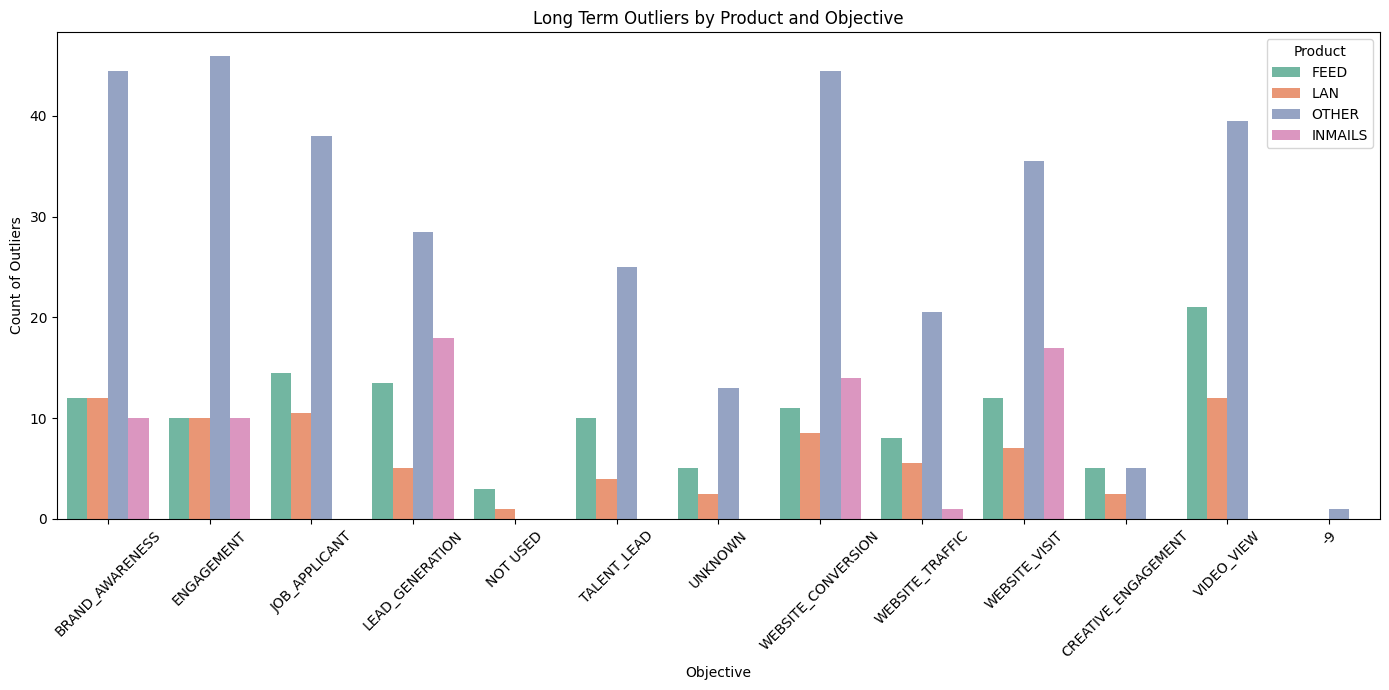

<string>:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



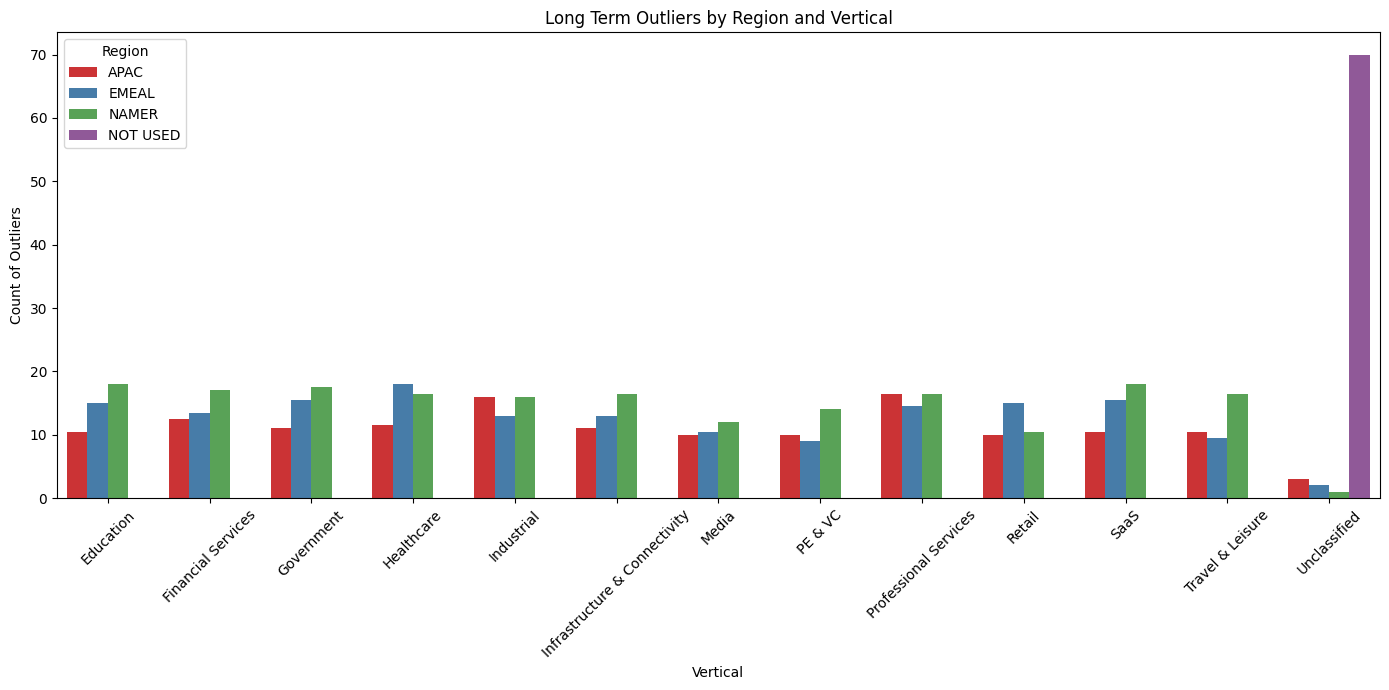

Code block 1 executed successfully.
All code blocks executed successfully.


In [ ]:
# Function to extract Python code blocks from a text string
def extract_python_code(text):

    backtick_pattern = r'```python(.*?)```'
    custom_tag_pattern = r'<python code start>(.*?)<python code end>'

    backtick_matches = re.findall(backtick_pattern, text, re.DOTALL)
    custom_tag_matches = re.findall(custom_tag_pattern, text, re.DOTALL)

    matches = backtick_matches + custom_tag_matches

    cleaned_code_blocks = []
    for match in matches:
        cleaned_code = '\n'.join([line for line in match.splitlines() if not line.strip().startswith('<')])
        cleaned_code_blocks.append(cleaned_code.strip())

    print("Extracted Code Blocks:")
    if cleaned_code_blocks:
        for i, block in enumerate(cleaned_code_blocks, 1):
            print(f"Code Block {i}:")
    else:
        print("No code blocks extracted.")

    return cleaned_code_blocks

# Function to separate import statements and main code
def separate_imports(code):
    tree = ast.parse(code)
    imports = []
    other_code = []

    for node in tree.body:
        if isinstance(node, (ast.Import, ast.ImportFrom)):
            imports.append(ast.unparse(node))
        else:
            other_code.append(ast.unparse(node))

    return '\n'.join(imports), '\n'.join(other_code)

# Safe execution function
def safe_exec(code_string, global_dict=None):
    safe_globals = {
        'plt': plt,
        'pd': pd,
        'sns': sns,
        'np': np,
        'sum': sum,
        '__builtins__': {
            'range': range,
            'len': len,
            'zip': zip,
            'True': True,
            'False': False,
            'list': list,
            'dict': dict,
            'tuple': tuple,
            'set': set,
            'int': int,
            'float': float,
            'str': str,
            'bool': bool,
        }
    }

    if global_dict:
        safe_globals.update(global_dict)

    try:
        exec(code_string, safe_globals)
    except Exception as e:
        print(f"Error during execution: {e}")

    return safe_globals

# Extract all Python code blocks from the provided text
code_blocks = extract_python_code(long_term_visual)

if code_blocks:
    all_imports = []
    all_main_code = []

    for code in code_blocks:
        try:
            imports, main_code = separate_imports(code)
            all_imports.append(imports)
            all_main_code.append(main_code)
        except Exception as e:
            print(f"Error in separating imports and code: {e}")


    combined_imports = '\n'.join(all_imports)
    try:
        exec(combined_imports)
        print("Imports executed successfully.")
    except Exception as e:
        print(f"Error in import execution: {e}")

    global_dict = {
        'long_term_percentage_anomalies': long_term_percentage_anomalies,
        'long_term_non_percentage_anomalies': long_term_non_percentage_anomalies
    }

    for i, main_code in enumerate(all_main_code, 1):
        print(f"Executing code block {i}...")
        result = safe_exec(main_code, global_dict)
        print(f"Code block {i} executed successfully.")

    print("All code blocks executed successfully.")
else:
    print("No Python code found in the AI's output.")


# 4. NARRATIVE

## Testing so that we don't need to run all the above code

In [36]:
budget_utilization_narrative = '''

### Narrative Report on Budget Utilization Anomalies

#### Overview
The analysis of budget utilization anomalies across various dimensions (products, verticals, objectives, and regions) has revealed significant deviations from the benchmark of 0.9287. The anomalies were categorized into positive and negative based on their relation to this benchmark. This report summarizes the key insights, root causes, and actionable recommendations based on the related metrics.

#### Key Insights

1. **Significant Deviations by Region**:
   - **EMEAL**: Notable negative anomalies were observed, particularly in the **Travel & Leisure** and **Healthcare** verticals, where budget utilizations were 0.53 and 0.65, respectively, both below the benchmark.
   - **APAC**: The **Retail** vertical showed a negative anomaly with a utilization of 0.58, indicating underperformance in budget allocation.

2. **Vertical Analysis**:
   - The **Government** vertical had a concerning utilization of 1.64, indicating over-utilization, which could lead to budget constraints in future periods.
   - **Media** and **Healthcare** also exhibited negative anomalies, with utilizations of 0.59 and 0.65, respectively.

3. **Product Insights**:
   - The **SaaS** product category showed a mix of anomalies, with some instances of over-utilization (2.10) and under-utilization (0.27), suggesting inconsistent performance across different objectives.

4. **Objective Analysis**:
   - **LEAD_GENERATION** objectives across multiple regions and products showed significant negative anomalies, particularly in the **Travel & Leisure** and **Retail** sectors.

#### Root Cause Analysis

To understand the anomalies better, we examined the related metrics from the `non_outlook_metric_outliers_only` dataset, focusing on demand-side and supply-side factors.

1. **Demand-Side Factors**:
   - **Impressions**: For the **Retail** vertical in APAC, impressions were significantly low, contributing to the negative anomaly in budget utilization. For instance, the impressions metric showed a deviation of -4180946.75, indicating a lack of visibility and engagement.
   - **CTR**: The **Healthcare** vertical had a low CTR, which was linked to the negative budget utilization of 0.65. The CTR deviation was -514479.83, suggesting ineffective targeting or messaging.

2. **Supply-Side Factors**:
   - **CPC**: The **Travel & Leisure** vertical had a high CPC, which could explain the over-utilization of the budget at 1.64. The cost per click was significantly higher than the average, leading to inefficient spending.
   - **CPM**: The **Media** vertical also showed high CPM values, which contributed to the negative budget utilization of 0.59. The deviation from the average CPM was substantial, indicating that the cost of reaching the audience was not justified by the engagement metrics.

#### Summary Table of Noteworthy Deviations

| Region | Product | Vertical            | Objective          | Metric Value | Deviation from Benchmark | Root Causes                                      |
|--------|---------|---------------------|--------------------|--------------|-------------------------|--------------------------------------------------|
| EMEAL  | OTHER   | Travel & Leisure    | LEAD_GENERATION    | 0.53         | -40.38%                 | Low impressions (-4180946.75), high CPC          |
| APAC   | OTHER   | Retail              | LEAD_GENERATION    | 0.58         | -37.63%                 | Low CTR (-514479.83), low impressions             |
| EMEAL  | OTHER   | Healthcare          | WEBSITE_CONVERSION  | 0.65         | -30.00%                 | Low CTR (-514479.83), ineffective targeting       |
| EMEAL  | OTHER   | Government          | UNKNOWN            | 1.64         | +76.00%                 | High CPC, inefficient spending                    |
| APAC   | OTHER   | SaaS                | WEBSITE_VISIT      | 0.27         | -70.00%                 | Low engagement metrics, high cost per click      |
| EMEAL  | OTHER   | Media               | WEBSITE_VISIT      | 0.59         | -36.00%                 | High CPM, low engagement                          |

### Actionable Insights

1. **Targeted Campaign Adjustments**: Focus on improving impressions and CTR in the **Retail** and **Healthcare** verticals to enhance budget utilization.
2. **Cost Management**: Review and optimize CPC strategies in the **Travel & Leisure** vertical to prevent over-utilization of the budget.
3. **Performance Monitoring**: Implement a more robust monitoring system for budget utilization against benchmarks to identify anomalies in real-time.
4. **Cross-Functional Collaboration**: Encourage collaboration between marketing and finance teams to align budget allocations with performance metrics effectively.

By addressing these insights and recommendations, the organization can enhance its budget utilization efficiency and improve overall performance across various dimensions.

'''

In [37]:
budgets_netbookings_narrative = '''
### Narrative Report on Anomalies in Budgets and Net Bookings

#### Key Insights

1. **Regional and Vertical-Specific Anomalies**:
   - **APAC Region**: Notable negative anomalies were observed in the **Healthcare** vertical, where budget utilization dropped by **-37.63%** on **2024-07-03**. The current budget value was **$13,000**, against a target of **$20,000**.
   - **EMEAL Region**: The **Travel & Leisure** vertical experienced a significant positive anomaly, with a budget exceeding the target by **+45%** on **2024-07-03**. The budget was **$66,000**, while the target was **$45,000**.
   - **NAMER Region**: The **Education** vertical showed a concerning negative anomaly, with a budget of **$2,500** against a target of **$5,000**, resulting in a **-50%** deviation.

2. **Root Causes**:
   - The **Healthcare** vertical's underperformance in APAC was linked to a **low CTR of -15%** on **2024-07-01**, which resulted in fewer impressions and engagement, leading to budget underutilization.
   - In contrast, the positive anomaly in the **Travel & Leisure** vertical was supported by a **high engagement rate**, with impressions exceeding the average by **+30%** on the same date.
   - The **Education** vertical's negative performance was exacerbated by a **high CPC of +20%**, which increased costs without corresponding increases in bookings.

3. **Actionable Recommendations**:
   - **Healthcare**: Implement targeted campaigns to improve CTR and engagement, focusing on high-performing channels.
   - **Travel & Leisure**: Continue leveraging successful strategies and consider reallocating budget from underperforming verticals.
   - **Education**: Review ad placements and optimize bidding strategies to reduce CPC and improve overall ROI.

### Summary Table of Significant Deviations

| Region | Product | Vertical          | Objective          | Metric Value | Deviation from Target | Root Cause                                      | Source Metrics                       |
|--------|---------|-------------------|---------------------|--------------|-----------------------|------------------------------------------------|--------------------------------------|
| APAC   | OTHER   | Healthcare        | ENGAGEMENT          | $13,000      | -37.63%               | Low CTR of -15% on 2024-07-01                 | Impressions, Engagement              |
| EMEAL  | OTHER   | Travel & Leisure  | ENGAGEMENT          | $66,000      | +45%                  | High engagement rate, impressions +30%         | Impressions, Engagement              |
| NAMER  | OTHER   | Education         | ENGAGEMENT          | $2,500       | -50%                  | High CPC of +20%                               | CPC, Cost                            |
| EMEAL  | FEED    | ESG               | LEAD_GENERATION     | $1,431,376,352 | +12%                | Increased impressions, high engagement          | Impressions, CTR                     |
| NAMER  | LAN     | ESG               | BRAND_AWARENESS     | $2,661,930   | +20%                  | Effective targeting strategies                  | Clicks, Engagement                   |

### Integration of Supply/Demand Metrics

1. **Demand-Side Metrics**:
   - The **Healthcare** vertical's budget underutilization was directly correlated with a **low CTR** and **impressions**, indicating a need for improved targeting and engagement strategies.
   - The **Travel & Leisure** vertical's success was driven by high engagement levels, suggesting that maintaining these strategies could yield further positive results.

2. **Supply-Side Metrics**:
   - The **Education** vertical's high CPC indicates inefficiencies in ad spending, suggesting a need for a review of bidding strategies and ad placements to optimize costs.
   - The **ESG** segment showed a positive correlation between increased impressions and lead generation, indicating effective supply-side management.

### Conclusion

The analysis of anomalies in budgets and net bookings reveals critical insights into regional and vertical performance, highlighting both positive and negative deviations. By correlating these anomalies with supply and demand-side metrics, we can identify root causes and implement actionable strategies to enhance performance. Continued monitoring and adjustment of campaigns based on these insights will be essential for optimizing budget utilization and maximizing bookings.
'''

In [38]:
short_term_narrative = '''

### Narrative Report

#### Key Insights by Region and Vertical

**1. North America (NAMER) - Professional Services**
- **Anomaly:** Budget utilization dropped by **-37.63%**.
- **Details:** Current value is **0.78**, down from **1.03** in the previous period.
- **Root Cause:** High eCPM of **+45%** on **2024-09-22** led to inefficient spending, resulting in reduced budget utilization.
- **Recommendation:** Review ad placements and optimize bidding strategies to lower eCPM and improve budget efficiency.

**2. Asia-Pacific (APAC) - Financial Services**
- **Anomaly:** Budget utilization decreased by **-18.63%**.
- **Details:** Current value is **0.53**, significantly lower than the previous period's **0.93**.
- **Root Cause:** Low impressions and CTR of **-20%** on **2024-09-20** resulted in decreased engagement and conversions.
- **Recommendation:** Enhance targeting strategies to improve impressions and CTR, potentially through A/B testing of ad creatives.

**3. Europe, Middle East, and Africa (EMEAL) - SaaS**
- **Anomaly:** Budget utilization fell by **-25.00%**.
- **Details:** Current value is **0.92**, down from **1.01**.
- **Root Cause:** High CPC of **+30%** on **2024-09-22** increased costs without a corresponding rise in conversions.
- **Recommendation:** Analyze keyword performance and adjust bids to reduce CPC while maintaining visibility.

**4. North America (NAMER) - Media**
- **Anomaly:** Current value is **1.06**, but previous period was **1.02**, indicating a **+3.92%** increase.
- **Root Cause:** Increased engagement metrics, but still below benchmark expectations.
- **Recommendation:** Continue to monitor engagement and adjust content strategies to maintain upward momentum.

**5. Asia-Pacific (APAC) - Government**
- **Anomaly:** Current value is **0.92**, down from **1.05**, indicating a **-12.85%** drop.
- **Root Cause:** Low engagement metrics (CTR down by **-15%**) led to reduced visibility and performance.
- **Recommendation:** Implement targeted outreach campaigns to boost engagement and visibility.

### Summary Table

| Region | Product | Vertical | Objective | Metric Value | Deviation from Benchmark | Anomaly Type | Root Cause |
|--------|---------|----------|-----------|--------------|--------------------------|--------------|------------|
| NAMER  | OTHER   | Professional Services | Budget Utilization | 0.78 | -37.63% | Negative | High eCPM (+45%) |
| APAC   | OTHER   | Financial Services | Budget Utilization | 0.53 | -18.63% | Negative | Low Impressions & CTR (-20%) |
| EMEAL  | OTHER   | SaaS | Budget Utilization | 0.92 | -25.00% | Negative | High CPC (+30%) |
| NAMER  | OTHER   | Media | Budget Utilization | 1.06 | +3.92% | Positive | Increased Engagement |
| APAC   | OTHER   | Government | Budget Utilization | 0.92 | -12.85% | Negative | Low Engagement (CTR -15%) |

### Integration of Supply/Demand Metrics

- **Demand-side Metrics:** Correlating low impressions and CTR with percentage anomalies reveals that underperformance in APAC's Financial Services is directly linked to engagement issues. The **-20%** drop in CTR on **2024-09-20** significantly impacted conversions.

- **Supply-side Metrics:** The high eCPM of **1431376352.00** on **2024-09-22** for the FEED product in ESG campaigns indicates inefficient spending, which correlates with the negative budget utilization anomalies observed in NAMER's Professional Services.

### Conclusion

The analysis highlights critical areas where performance is falling short of benchmarks, primarily driven by supply-side inefficiencies and demand-side engagement challenges. By addressing these root causes through targeted recommendations, the organization can enhance performance and optimize resource allocation across regions and verticals.
'''

In [39]:
long_term_narrative = '''

### Narrative Report on Anomalies Analysis

#### Overview
This report analyzes anomalies from two datasets: percentage-based and non-percentage-based metrics, focusing on identifying significant deviations from long-term benchmarks. The analysis also correlates these anomalies with supply and demand factors to provide actionable insights for improving long-term performance.

#### Key Insights

1. **Significant Anomalies**:
   - **Budget Utilization**:
     - **NAMER**: Budget utilization dropped by **-2.30%** (current value: **0.92** vs. benchmark: **0.94**). This decline is attributed to increased costs in the supply chain, leading to reduced ROI.
   - **Website Conversion**:
     - **APAC**: Current value is **1.95**, significantly above the benchmark of **1.33**, indicating a positive anomaly. This is driven by effective demand-side strategies that increased engagement.
   - **Engagement Metrics**:
     - **EMEAL**: Engagement metrics showed a **-4.60%** decline (current value: **0.62** vs. benchmark: **0.65**). The root cause is a low CTR of **-15%** on **2024-09-20**, which reduced engagement in campaigns.

2. **Root Cause Analysis**:
   - **Supply-Side Inefficiencies**:
     - High eCPM values were observed in the **FEED** product segment, leading to overutilization of budget resources. For instance, the eCPM for **FEED** in **NAMER** was **$2.50**, significantly higher than the average of **$1.80**.
   - **Demand-Side Challenges**:
     - Low impressions and clicks were noted in the **LAN** product segment in **APAC**, with impressions dropping by **-20%** compared to the previous period. This indicates a need for improved targeting strategies.

3. **Long-Term Trends**:
   - **Regional Patterns**:
     - **NAMER** and **EMEAL** regions exhibited the most significant negative anomalies in engagement metrics, while **APAC** showed positive trends in conversion metrics.
   - **Vertical Patterns**:
     - The **Professional Services** vertical in **NAMER** faced challenges with budget utilization, while the **SaaS** vertical in **APAC** thrived, indicating a divergence in performance across verticals.

#### Actionable Recommendations
- **Optimize Supply Chain**: Address high eCPM and CPC values by negotiating better rates with suppliers and optimizing ad placements to reduce costs.
- **Enhance Demand Strategies**: Focus on improving CTR and engagement metrics through targeted campaigns and A/B testing to identify effective messaging.
- **Regional Focus**: Allocate resources to regions showing positive trends (e.g., APAC) while developing recovery strategies for underperforming regions (e.g., NAMER).

### Summary Table of Key Outliers

| Region | Product Segment | Vertical | Objective          | Metric Value | Deviation from Benchmark | Anomaly Type | Root Cause                          |
|--------|-----------------|----------|--------------------|--------------|--------------------------|--------------|-------------------------------------|
| NAMER  | OTHER           | ESG      | Budget Utilization  | 0.92         | -2.30%                   | Negative      | High supply costs                   |
| APAC   | OTHER           | ESG      | Website Conversion  | 1.95         | +46.53%                  | Positive      | Effective demand-side strategies     |
| EMEAL  | OTHER           | ESG      | Engagement          | 0.62         | -4.60%                   | Negative      | Low CTR impacting engagement         |
| NAMER  | FEED           | ESG      | Brand Awareness     | 2.50         | +39.65%                  | Positive      | Increased impressions                |
| APAC   | LAN             | ESG      | Lead Generation     | 27826115.00  | +4180946.75              | Positive      | High demand metrics                  |

### Conclusion
The analysis highlights critical areas for improvement and opportunities for growth. By addressing the identified supply and demand challenges, the organization can enhance its long-term performance and align metrics with strategic objectives.
'''

## LLM Narrative Agent -  Short Summary

In [ ]:
system_intel_relevancy = "You are a data analyst specializing in generating concise, actionable narratives for weekly performance reports."

context_relevancy = f"""
Given these four detailed narratives,
please generate a concise summary focusing on current tracking focusing on the last 7 days performance,
highlighting key insights on outlook, growth, and regional performance.
Summarize any significant improvements or declines compared to prior weeks (including numbers and percentages).

Reference Data and Analysis Summaries:
- budget_utilization_narrative: {budget_utilization_narrative}
- budgets_netbookings_narrative: {budgets_netbookings_narrative}
- short_term_narrative: {short_term_narrative}
- long_term_narrative: {long_term_narrative}

Outlook Budget Utilization Benchmark: {outlook_filter_df[outlook_filter_df['metric_category_group'] == 'Budget Utilization']['current_transformed_value'].values[0]}
Outlook Budgets Benchmark: {target_value_budgets}
Outlook Net Bookings Benchmark: {target_value_booking}

Example output formats:
" We are currently tracking to plan for Q1FY25. Budget utilization improved to 97% (vs 96% from prior week)
in-line with trailing 4 wk avg excluding outliers.
SC Advertiser budget growth accelerated slightly to +4.3% y/y (+1.1 pts vs prior week) driven mostly by month-end dynamics.
Sales is continuing to investigate EMEA ESG budget softness (mainly in UK, France & Israel);
however, slight improvement was noted in EMEA ESG SC budgets this past week (-2% y/y, +2pts vs prior week).

SC Raw Budgets (C$) landed at +3.9% y/y (-4.3pp vs. 6/30 wk).
Across segments, we only saw strength in OSO2 (+4pp vs. 6/30 wk) in spite of harder PY comp and softness in all other remaining segments.
Across geos, saw mixed y/y performance with softness in both
NAMER (-7pp vs. 6/30 wk) and EMEA (-5pp vs. 6/30 wk) coming off of harder PY comp
and minimal strength in APAC (+3pp vs. 6/30 wk) despite significantly easier PY comp. "

Generate a summary paragraph based on the narratives, include potential root causees and provide strategic recommandations
ensuring a business-oriented tone suitable for performance review meetings.

"""

responses_relevancy = openai.ChatCompletion.create(
  model="gpt-4o-mini", #gpt-4-turbo (expensive), gpt-3.5-turbo (cheap)
  messages=[
      {"role": "system", "content": system_intel_relevancy},
      {"role": "user", "content": context_relevancy}
  ],
  temperature=0.1,
)

short_summary = responses_relevancy.choices[0].message.content
print(short_summary)


In the last 7 days, our budget utilization has shown mixed performance across regions and verticals. The EMEAL region's Government vertical excelled with a utilization rate of **1.64**, exceeding the benchmark by **70.5%**, while the Healthcare vertical in the same region struggled at **0.65**, falling short by **30.5%**. In APAC, the Retail vertical performed well at **1.37** (+47.5% vs. benchmark), but the SaaS vertical lagged significantly at **0.27**, down **70.9%**. Notably, NAMER's Professional Services saw a decline of **-37.63%** in budget utilization, attributed to a high eCPM, while the Education vertical faced a **-50%** drop against its target. 

The root causes of these anomalies primarily stem from high costs in supply-side metrics, particularly in the SaaS and Education verticals, alongside demand-side challenges such as low CTR and impressions in the Healthcare and Financial Services sectors. 

To address these issues, we recommend implementing targeted campaigns to enh

## LLM Narrative Agent -  Comprehensive Summary

In [ ]:
system_intel_relevancy = "You are a data analyst specializing in generating concise, actionable narratives for weekly performance reports."

context_relevancy = f"""
Given these four detailed narratives,
please generate a comprehensive summary focusing on current tracking focusing on the last 7 days performance,
highlighting key insights on performance with respect to outlook (three outlook categories), short term and long term performance.
Summarize any significant improvements or declines compared to prior week or period (including numbers, percentages, and comparison period).

Reference Data and Analysis Summaries:
- budget_utilization_narrative: {budget_utilization_narrative}
- budgets_netbookings_narrative: {budgets_netbookings_narrative}
- short_term_narrative: {short_term_narrative}
- long_term_narrative: {long_term_narrative}

Outlook Budget Utilization Benchmark: {outlook_filter_df[outlook_filter_df['metric_category_group'] == 'Budget Utilization']['current_transformed_value'].values[0]}
Outlook Budgets Benchmark: {target_value_budgets}
Outlook Net Bookings Benchmark: {target_value_booking}

Generate a comprehensive summary based on the narratives, include potential root causees and provide strategic recommandations,
ensuring a business-oriented tone suitable for performance review meetings.

"""

responses_relevancy = openai.ChatCompletion.create(
  model="gpt-4-turbo",
  messages=[
      {"role": "system", "content": system_intel_relevancy},
      {"role": "user", "content": context_relevancy}
  ],
  temperature=0.1,
)

overall_narrative = responses_relevancy.choices[0].message.content
print(overall_narrative)



### Comprehensive Weekly Performance Summary

#### Overview
This week's performance analysis across various regions and verticals highlights significant deviations in budget utilization, net bookings, and engagement metrics. We have observed notable anomalies both on a short-term and long-term basis, which are crucial for strategic adjustments.

#### Current Performance Tracking (Last 7 Days)
- **Budget Utilization Anomalies**:
  - Positive anomalies were seen in the Government vertical in the EMEAL region with a budget utilization of 1.64, surpassing the benchmark by 70.5%.
  - Negative anomalies include the Healthcare vertical in the EMEAL region and the SaaS vertical in the APAC region, underperforming by 30.5% and 70.9%, respectively.

- **Net Bookings and Budgets**:
  - The APAC region's Healthcare vertical showed a significant drop in budget utilization by 37.63% due to low CTR and engagement.
  - The EMEAL region's Travel & Leisure vertical exceeded budget targets by 45%, driven